In [1]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container { width: 95%;} div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style> """))
 
# %matplotlib inline

import os
import sys
import platform
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf
from flopy.export.shapefile_utils import shp2recarray
from rasterio import Affine
from flopy.utils.reference import SpatialReference
from flopy.utils.postprocessing import get_transmissivities, get_water_table, get_gradients

import shapefile    # not used directly here but for some reason flopy needs this to do shapefile stuff and BTW its not import pyshp as you would think its import shapefile, dumb...
import pandas as pd
import fiona
from rasterio.features import rasterize
import rasterio
import rasterio.mask
import geopandas
from osgeo import gdal

#import simplekml
import ogr
from shapely.wkb import loads

from scipy.interpolate import interp2d
import scipy.optimize as opt


print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

#Set name of MODFLOW exe
#  assumes executable is in users path statement
exe_name = 'mf2005'
if platform.system() == 'Windows':
    exe_name = 'mf2005.exe'

workspace = os.path.join("..", "..", 'RISA_yr6_GIT_ignored_files', 'Flo_py_wrkspace4')
#make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)
    
tempspace = os.path.join(workspace, "temp")
#make sure workspace directory exists
if not os.path.exists(tempspace):
    os.makedirs(tempspace)
    
figurespace = os.path.join(workspace, "Figures")
if not os.path.exists(figurespace):
    os.makedirs(figurespace)
    
WGS84UTM2S_string = 'PROJCS["WGS_1984_UTM_Zone_2S",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-171],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1]]'
pd.set_option('display.max_rows', 75)

# define the spatial reference object 
model_epsg = 32702   # epsg code specifying coordinate reference system: in this case, UTM zone 2S, WGS 84, A proj4 string has also been fetched from <spatialreference.org> using the supplied epsg code.

# in line plotting and saving options. Change these to plot or not to plot inline
Plotnsave_plot = True
Plotnsave_save = True

ModuleNotFoundError: No module named 'flopy'

# Model geometry notes


model boundaries square at 
X	Y
- 530200	8425825
- 537700	8425825
- 537700	8418325
- 530200	8418325

with length of 7500 m on both sides


next steps 
- try and just follow existing github model notebook 

Shapefile Boundaries: (530200.0, 8418325.0, 537700.0000000009, 8425825.000000002)
wrote ..\..\RISA_yr6_GIT_ignored_files\Flo_py_wrkspace4\Model_polyarea.shp
wrote ..\..\RISA_yr6_GIT_ignored_files\Flo_py_wrkspace4\Model_grid.shp


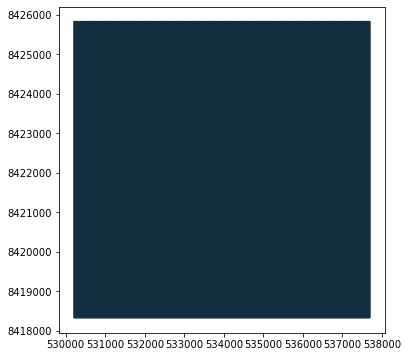

In [69]:
''' Define the number of layers, rows and columns.'''
# Note works at 100, 150, 300, 750
# Does not work at 600

ncol = 1500
nrow = 1500
nlay = 1

# model run times
nper = 1                     # Number of model stress periods (the default is 1)
perlen = [3650]              # An array of the stress period lengths in days separated by commas
nstp = [1]      # Number of time steps in each stress period (default is 1).
save_head = [3650]
steady = True
rotation = 0                             # rotation (positive counterclockwise)

# this cell inports the boundary shapefile to make the model around
ra = shp2recarray(os.path.join("..", "Data/Raw/GIS", 'model_square.shp'))
# these are the bondaries of the shapefile
shp_xmin = round(ra.geometry[0].bounds[0],1)
shp_ymin = round(ra.geometry[0].bounds[1],1)
shp_xmax = round(ra.geometry[0].bounds[2],1)
shp_ymax = round(ra.geometry[0].bounds[3],1)
print("Shapefile Boundaries: {}".format(ra.geometry[0].bounds))  

xll = int(shp_xmin)  # Lower left corner of model grid  
yll = int(shp_ymin)   # Lower left corner of model grid 


# grid spacing as a percentage of model x domain (in model units) note 10% buffer around boundary
delr = abs(int((shp_xmax-shp_xmin)/ncol))   # the width of each cell
delc = abs(int((shp_ymax-shp_ymin)/nrow))   # the height of eech cell
delr_4_sr  = np.ones(ncol, dtype=float) * delr    # This just puts the above into an array for the sr object 
delc_4_sr = np.ones(nrow, dtype=float) * delc   

# create the model boundary area polygon
sr = SpatialReference(delr=[delr_4_sr.sum()], delc=[delc_4_sr.sum()], xll=xll, yll=yll, rotation=rotation, proj4_str=WGS84UTM2S_string, lenuni=2) #  # model length units (1 for feet, 2 for meters (default)) (also calculeted uper left corner of model) 
sr.write_shapefile(os.path.join(workspace, 'Model_polyarea.shp'))          # write a shapefile of the model area for later use
prj = open(os.path.join(workspace, 'Model_polyarea.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()     # write the .prj file manually
#print("corners are at {}".format(sr.get_extent()))

# create the model boundary grid polygon   (NOTE THIS MUST OVERWRITE THe PREVIOUS sr. definition!)
sr = SpatialReference(delr=delr_4_sr, delc=delc_4_sr, xll=xll, yll=yll, rotation=rotation, proj4_str= '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs' , lenuni=2) #  # model length units (1 for feet, 2 for meters (default)) (also calculeted uper left corner of model) 
sr.write_shapefile(os.path.join(workspace, 'Model_grid.shp'))          # write a shapefile of the model grid for later use
prj = open(os.path.join(workspace, 'Model_grid.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()   # write the .prj file manually

# output control parameters
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}    

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize=(12,6))
    Tutuila = geopandas.read_file(os.path.join("..", "Data/Raw/GIS", 'model_square.shp'))
    Grid = geopandas.read_file(os.path.join(workspace, 'Model_grid.shp'))
    Grid.plot(ax=ax, facecolor="white", edgecolor="Black", linewidth=.2)
    Tutuila.plot(ax=ax, linewidth=2, alpha = .3)

### Assign Layer elevations from a DEM

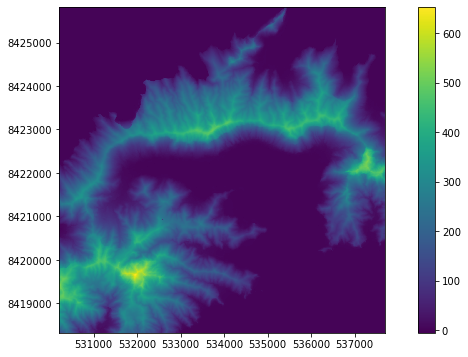

In [70]:
#Set model top to DEM
# Needed to clip the raster to appropriate dimensions, () https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html)
Raster_2_Clip = os.path.join("..",  'Data/Raw/GIS/3m_DEM', '3m_dem_cp.tif')
Clipped_raster = os.path.join(workspace, "DEM_10m_clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features,
                                                        crop=True)
out_meta = src.meta.copy()

out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(Clipped_raster, "w", **out_meta) as dest:
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
Top_raw = np.loadtxt(Clipped_raster, skiprows=7)   # the 7th row was a no data row for some reason not sure why, if another DEM is used might need to skiprows back to 6

y = np.linspace(0, np.shape(Top_raw)[0]-1, np.shape(Top_raw)[0])   
x = np.linspace(0, np.shape(Top_raw)[1]-1, np.shape(Top_raw)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, Top_raw, kind='cubic')
top = f(x2, y2)

botm = -500    # this will clearly need to change to accomadate the Tutuila bathymetry
top = np.where(top <= botm, botm+10, top) # force top elevations to always be higher than bottom elevations

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(top, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

Starting heads will be tricky.  Easiest might be to assign starting heads of 0.01 in ocean, then heads of 10 m less than top elevation in land surface areas, if optimization yields different starting heads then can modify. could also use the ending heads from the regional model. 


overall, I bound needs to be 

### starting heads

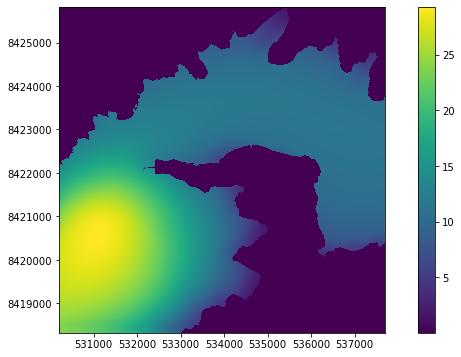

In [71]:
## First import regional heads from the regional model

Raster_2_Clip = os.path.join("..",  'Data/From_regional', 'PyPCGA_model_Heads_Clip.tif')
Clipped_raster = os.path.join(workspace, "PyPCGA_model_Heads_Clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features,
                                                        crop=True)
out_meta = src.meta.copy()

out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(Clipped_raster, "w", **out_meta) as dest:
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
Top_raw = np.loadtxt(Clipped_raster, skiprows=7)   # the 7th row was a no data row for some reason not sure why, if another DEM is used might need to skiprows back to 6

y = np.linspace(0, np.shape(Top_raw)[0]-1, np.shape(Top_raw)[0])   
x = np.linspace(0, np.shape(Top_raw)[1]-1, np.shape(Top_raw)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, Top_raw, kind='cubic')
regional_Heads = f(x2, y2)

#botm = -500    # this will clearly need to change to accomadate the Tutuila bathymetry
#top = np.where(top <= botm, botm+10, top) # force top elevations to always be higher than bottom elevations


# then explicitly say that the ocean area has a specified head, since the regional heads are fuzzy

with fiona.open(os.path.join("..",  'Data/Raw/GIS/ibounds/For_heads', 'Land_Ocean.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['OceanCell'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
mask = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

masked_heads = abs(regional_Heads)*mask                        # set ocean cells to a negative number through multoplication with -1
Ocean_starting_head = 0.01   # in meters 
start_heads = np.where(masked_heads < 0, Ocean_starting_head, masked_heads) # Set ocean cells (defined as any negative values in the array) to Ocean_starting_head value

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(start_heads, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

### make new ibound and specified head 
- Negative ibound (-1) is constant head
- Ibound of (0) is inactive
- Any positive Ibound (1) is variable head (active) 

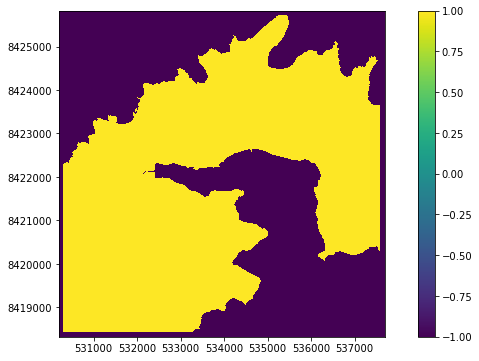

In [72]:
#### Use a Tutuila polygon to define the model active area as the island and the ghb cells as the offshore cells

with fiona.open(os.path.join("..", 'Data/Raw/GIS/ibounds', 'ibound_specHd_w_100m_buff.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['ibound'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
ibound = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(ibound, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

### Create Drains 
this takes a minute

<ipython-input-73-5075919393dc>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersections['RastVal'][intersections['RastVal'] > 3] = intersections['RastVal'] - 1
<ipython-input-73-5075919393dc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersections['RastVal'][intersections['RastVal'] == 0] = 0.1  #(will make pink box)


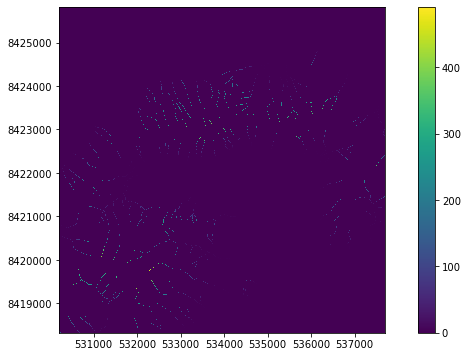

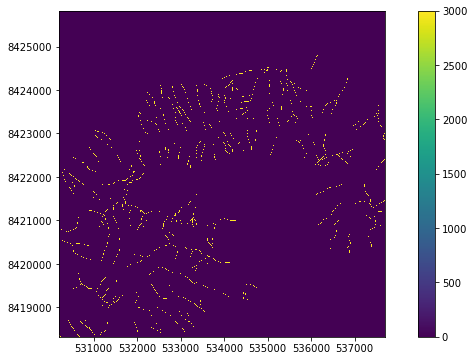

In [73]:
conductance_value = 3000

# Intersect streams with the grid cells using GEOPANDAS!! :)
lines = geopandas.GeoDataFrame.from_file(os.path.join("..", "Data/Raw/GIS", "Streams", 'Streams_All_WGS2S.shp'))
poly = geopandas.GeoDataFrame.from_file(os.path.join(workspace, 'Model_grid.shp'))
# Do the spatial intersect to just pull out cells that hit streams
intersections= geopandas.sjoin(poly, lines, how="inner", op='intersects')
intersections["x"] = intersections.centroid.x # pull out the x coordiate
intersections["y"] = intersections.centroid.y # pull out the y coordiate
intersections["Cond"] = conductance_value
# Write the geopandas dataframe to a esri shapefile 
intersections.to_file(driver = 'ESRI Shapefile', filename = os.path.join(workspace, 'Stream_grid_intersects.shp'))          # write a shapefile of the model grid for later use
prj = open(os.path.join(workspace, 'Stream_grid_intersects.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()   # write the .prj file manually

# Extract elevation values to the points from the DEM
Clipped_DEM_raster = os.path.join(workspace, "DEM_10m_clip.asc")   # from the DEM used above
src = rasterio.open(Clipped_DEM_raster) 
coords = [(x,y) for x, y in zip(intersections["x"], intersections["y"])]  # This woll pull the cooordinate values out of the centrods of the intersections frame above
intersections['RastVal'] = [x[0] for x in src.sample(coords)]

# Modify elevations a bit
intersections['RastVal'][intersections['RastVal'] > 3] = intersections['RastVal'] - 1

# Reset any values that ended up as 0s
intersections['RastVal'][intersections['RastVal'] == 0] = 0.1  #(will make pink box)

# Write to shapefile 
intersections.to_file(driver = 'ESRI Shapefile', filename = os.path.join(workspace, 'Stream_grid_intersects_Elevations.shp'))          # write a shapefile of the model grid for later use
prj = open(os.path.join(workspace, 'Stream_grid_intersects_Elevations.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()   # write the .prj file manually


# Create a model square array with the point values elevation as the elevation 
with fiona.open(os.path.join(workspace, 'Stream_grid_intersects_Elevations.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['RastVal'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
Stream_elev = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(Stream_elev, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

# Create a model square array with the point values conductance defined as whatever.
with fiona.open(os.path.join(workspace, 'Stream_grid_intersects_Elevations.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['Cond'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
Stream_conductance = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(Stream_conductance, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)


# Save in Flopy friendly format
drnElv_lst = pd.DataFrame({
                 'lay':  0,
                 'row':  np.nonzero(Stream_elev)[0], # + 1,
                 'col':  np.nonzero(Stream_elev)[1], # + 1,
                 'elv':  Stream_elev[np.nonzero(Stream_elev)],
                 'cond': Stream_conductance[np.nonzero(Stream_conductance)]}, 
             columns=['lay', 'row', 'col', 'elv', 'cond'])

# Convert the DataFrame into a list of lists for the drn constructor
stress_period_data = drnElv_lst.values.tolist()

# Create a dictionary, 1 entry for each of the stress periods.
stress_period_data_drain = {0: stress_period_data}    

### Pumping wells 
Using ASPA data and the average pumprates 2005-2017 based only last wells pumprate master sheet 

In [74]:
Pump_wells = pd.read_csv(os.path.join("..",  'Data/Raw/GIS/Pump_wells', 'ASPA_wells_clip_UTM2s.csv'))

Pump_wells['col_num'] = Pump_wells['x_utm'].apply(lambda x_utm_val: math.ceil((x_utm_val-xll)/delr) )          # this formula calculates the column number based on the x coordinate   Not sure why rows and cols are opposite what you think but they are
Pump_wells['row_num'] = Pump_wells['y_utm'].apply(lambda y_utm_val: (1+nrow)-math.ceil((y_utm_val-yll)/delc) )   # this formula calculates the row number based on the y coordinate 
Pump_wells['rowcol']  = list(zip(Pump_wells.row_num, Pump_wells.col_num)) 

# This takes obs wells that occupy the same cell and averages them! 
Unique_PumpWells = Pump_wells.groupby('rowcol', as_index=False).sum()                                               # Average the duplicate WLs that fall into a single cell, to get one "observed" water level for that cell 

# make new unique names for each obs point
Unique_PumpWells["name"] = "PumpWellCell_"+Unique_PumpWells.index.map(str)

# set layer values 
Unique_PumpWells["Layer"] = 0

# Convert GPM to m3/d
Unique_PumpWells["m3pd"] = Unique_PumpWells["PumpGMP"]*-5.45099

SP_frame = Unique_PumpWells[['Layer', 'row_num', 'col_num', 'm3pd']]

stress_period_data = SP_frame.values.tolist()
# Create a dictionary, 1 entry for each of the stress periods.
stress_period_data_PmpWells = {0: stress_period_data}

### Observation points

note need to cut out obs that are not within the model domain

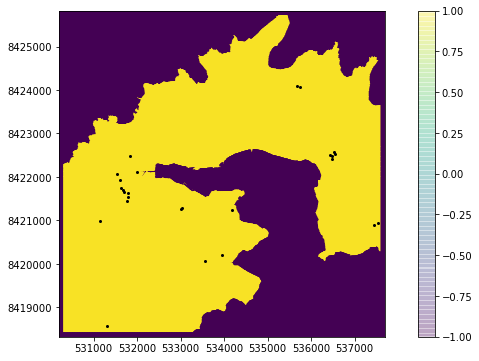

In [75]:
Pdevel_WLs = pd.read_csv(os.path.join("..",  'Data/Raw/Water_levels', 'Predevelop_WLs_MOD_vai183.csv'))

# Cut out observations that are outside of the model square (dont need the y's but could add those too for shoots and giggls
Pdevel_WLs = Pdevel_WLs[Pdevel_WLs['x_utm'] > shp_xmin]
Pdevel_WLs = Pdevel_WLs[Pdevel_WLs['x_utm'] < shp_xmax]

Pdevel_WLs['col_num'] = Pdevel_WLs['x_utm'].apply(lambda x_utm_val: math.ceil((x_utm_val-xll)/delr) )          # this formula calculates the column number based on the x coordinate   Not sure why rows and cols are opposite what you think but they are
Pdevel_WLs['row_num'] = Pdevel_WLs['y_utm'].apply(lambda y_utm_val: (1+nrow)-math.ceil((y_utm_val-yll)/delc) )   # this formula calculates the row number based on the y coordinate 
Pdevel_WLs['rowcol']  = list(zip(Pdevel_WLs.row_num, Pdevel_WLs.col_num))                                      # just make a tuplel of the row and col

# This takes obs wells that occupy the same cell and averages them! 
Unique_WLs = Pdevel_WLs.groupby('rowcol', as_index=False).mean()                                               # Average the duplicate WLs that fall into a single cell, to get one "observed" water level for that cell 

# make new unique names for each obs point
Unique_WLs["name"] = "Obs_"+Unique_WLs.index.map(str)

nobs = len(Unique_WLs['WL_m_MSL']) 
layervals = [0] * nobs
rowvals = list(Unique_WLs['row_num'].astype(int))
colvals = list(Unique_WLs['col_num'].astype(int))
obsvals = list(Unique_WLs['WL_m_MSL'])
obsnames = list(Unique_WLs["name"])

if Plotnsave_plot: 
    gdf = geopandas.GeoDataFrame(Unique_WLs, geometry=geopandas.points_from_xy(Unique_WLs.x_utm, Unique_WLs.y_utm))
    fig, ax = plt.subplots(figsize = (12,6))
    Grid.plot(ax=ax, facecolor="white", edgecolor="Black", linewidth=.2, alpha = .2)
    qm = sr.plot_array(ibound, ax=ax, alpha = .2)
    ax.set_aspect(1); plt.colorbar(qm)
    gdf.plot(ax=ax, color='black', markersize=4)

### Import Recharge .asc from SWB output into MODFLOW rech array
(note I am not sure what happens when the model area is bigger then the raster....)

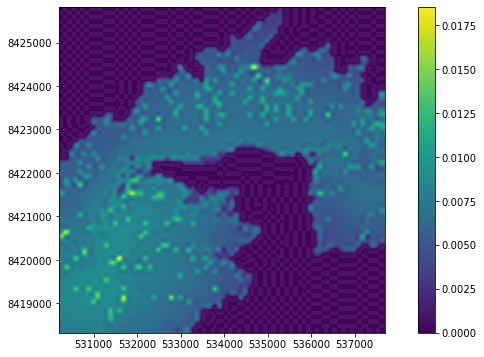

In [76]:
SWB_output_recharge = os.path.join("..",  'Data/Raw/GIS/Recharge','recharge_v1.asc')  

# Needed to clip the raster to appropriate dimensions, () https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html)   
Raster_2_Clip = os.path.join(SWB_output_recharge)
Clipped_raster = os.path.join(workspace, "raw_net_infiltration_clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    
out_meta = src.meta.copy()
out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(Clipped_raster, "w", **out_meta) as dest:          # create the new clipped .asc file
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
recharge_raw_SWB = np.loadtxt(Clipped_raster, skiprows=6)

y = np.linspace(0, np.shape(recharge_raw_SWB)[0]-1, np.shape(recharge_raw_SWB)[0])   
x = np.linspace(0, np.shape(recharge_raw_SWB)[1]-1, np.shape(recharge_raw_SWB)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, recharge_raw_SWB, kind='cubic')
recharge_resampled = f(x2, y2)
recharge_converted =  recharge_resampled* (0.0254/365)   # recharge comes out of SWB in inches/year and needs to be converted to m/day

recharge_converted = np.where(recharge_converted < 0, 0.001, recharge_converted)   # Interpolation made some negative values, fix that issue by setting them to a positive value

rch_data = {0: recharge_converted}   # dictionary form to specify that it is only on first layer

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(recharge_converted, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

### Hydraulic condictivty assigned based on zones as defined by shapefiles in a folder

The values at the top of this cell can be modified to change the conductivity in each zone

In [77]:
# Function to rasterize the HK zones: 
def rastah_zone(shp):
    with fiona.open(shp) as src:   #    read in Tutuila shapefile
            records = [r for r in src]   
    geoms = [r['geometry'] for r in records]       # shapefile shape
    attr = [r['properties'] for r in records]      # shapefile attributes
    geoms = [(g, attr[i]['par_code']) for i, g in enumerate(geoms)]              # select the attribute to map onto the raster grid
    # affine: work with the geometry to change from raster to grid reference frame 
    trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
    Outrastah = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 
    return Outrastah

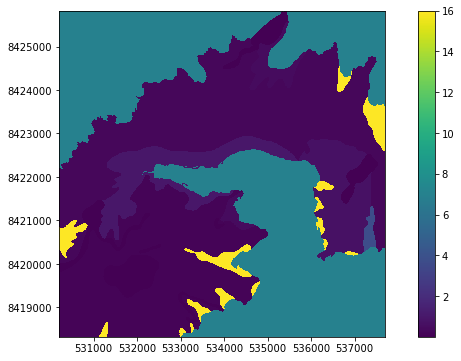

In [78]:
# set the  values this cell is set up for optimization
HK_raster = rastah_zone(os.path.join("..",  'Data/Raw/GIS/Geo_units/v2', 'NPS_simplified_geo_v2.shp'))

## Initial starting point before 3-4 rounds of calibration  was calgood = [ 5, 5, 5, 5, 5, 5, 0.2, .2, .2, .4, 0.5, 5]
#calgood =  [2.6, 39, 1, 14, 3.7, 1.2, 0.001, 0.37, 0.9, 0.7, 0.3, 1]

calgood = [0.7, 16, 16,  0.5, 1.0, 0.5, 0.002, 0.75, 0.17, 0.3, 0.0018, 3.75] 


Alluvium_Aua      = calgood[0]
Alluvium_Fagaalu  = calgood[1]
Alluvium_minor    = calgood[2]
Alluvium_Utulei   = calgood[3]
Alluvium_Vaipito  = calgood[4]
Alluvium_Vatia    = calgood[5]
Dikes             = calgood[6]
Pago_inner_E      = calgood[7]
Pago_inner_W      = calgood[8]
Pago_outer        = calgood[9]
Trachyte          = calgood[10]
Alluvium_Laulii   = calgood[11]


map_dic = {-12:Alluvium_Aua, 
           -14:Alluvium_Fagaalu, 
           -15:Alluvium_minor,
           -13:Alluvium_Utulei,
           -11:Alluvium_Vaipito,
           -10:Alluvium_Vatia,
           -50:Dikes,
           -30:Pago_inner_E,
           -40:Pago_inner_W,
           -20:Pago_outer,
           -60:Trachyte, 
           -16:Alluvium_Laulii}

for i in map_dic:
    HK_raster = np.where(HK_raster== i, map_dic[i], HK_raster)
    
HK_raster = np.where(HK_raster== 0, 7, HK_raster)   # this is for the areas not covered by HK zones, the number Should not actually maatter at all!

#HK_raster = np.where(HK_raster== -90, 1, HK_raster) # this is for the areas that get messed up somehow
#HK_raster = np.where(HK_raster== -70, 1, HK_raster) # this is for the areas that get messed up somehow

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(HK_raster, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

'''Define the layers to be confined and define the horizontal and vertical 
hydraulic conductivity of the aquifer for the LPF package.'''

# lpf data
laytyp = 0
vka = 10


In [79]:
modelname = 'modelface'

ml = flopy.modflow.Modflow(modelname, version='mf2005', exe_name=exe_name, model_ws=workspace, verbose=False)

discret = flopy.modflow.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol, laycbd=0,
                                   delr=delr, delc=delc, top=top, botm=botm,
                                   nper=nper, perlen=perlen, nstp=nstp)
bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=start_heads)
lpf = flopy.modflow.ModflowLpf(ml, laytyp=laytyp, hk=HK_raster, vka=vka)
#### ghb = flopy.modflow.ModflowGhb(ml, stress_period_data=ghb_data)
rch = flopy.modflow.ModflowRch(ml, rech=rch_data)
oc = flopy.modflow.ModflowOc(ml, stress_period_data=spd)
pcg = flopy.modflow.ModflowPcg(ml, hclose=1.0e-6, rclose=3.0e-3, mxiter=100, iter1=50)
drn = flopy.modflow.ModflowDrn(ml, ipakcb=53, print_flows=True, stress_period_data=stress_period_data_drain)  # ipakcb=53, is flag for writing SFR output to cell-by-cell budget (on unit 53)
wel = flopy.modflow.ModflowWel(model = ml, stress_period_data=stress_period_data_PmpWells)

# water level observations
obs_data= []
for i in range(0,nobs):
    obs = flopy.modflow.HeadObservation(ml, obsname=obsnames[i], layer=layervals[i], row=rowvals[i], column=colvals[i], time_series_data=[[0,obsvals[i]]])
    obs_data.append(obs)
hob = flopy.modflow.ModflowHob(ml, iuhobsv = 7, hobdry=-999, obs_data = obs_data)

# Run model 

if needed: #### Model checker
https://notebook.community/brclark-usgs/flopy/examples/Notebooks/flopy3_ModelCheckerExample
- ml.check()

In [80]:
ml.write_input()
ml.run_model(silent=False)

FloPy is using the following  executable to run the model: .\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: modelface.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/10/11  6:16:58

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2021/10/11  6:17:55
 Elapsed run time: 57.624 Seconds

  Normal termination of simulation


(True, [])

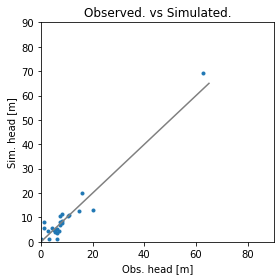

Mean Error: 0.36
Mean Absolute Error: 2.28
RMS Error: 3.14


In [83]:
# plot observations 
observations = np.loadtxt(os.path.join(workspace, '{}.hob.out'.format(modelname)), skiprows=1, usecols=[0,1])      # this block extracts observation data at each well field and determines what the maximum residual at any of the given points is
comp_obs = np.ravel(np.split(observations, 2, 1)[0]) # the computed hed values at the obspts
obs_obs = np.ravel(np.split(observations, 2, 1)[1]) # the observed hed values at the obspts

# note positive residuals means model is calculating too high negative is model calculates too low 
residuals = []
for idx, i in enumerate(observations):   
    r = observations[idx][0]-observations[idx][1]
    residuals.append(r)

Howd_we_do = pd.DataFrame({"Obs_hed_m":obs_obs,"Comp_hed_m":comp_obs,"Residual_m":residuals})

fig = plt.figure(figsize=(4,4))
plt.title('Observed. vs Simulated.')
plt.plot(Howd_we_do["Obs_hed_m"], Howd_we_do["Comp_hed_m"], '.')
#plt.axis('equal')
#plt.axis('square')
plt.xlabel("Obs. head [m]")
plt.ylabel('Sim. head [m]')
plt.ylim(0,90)
plt.xlim(0,90)

plt.plot([0,20,65],[0,20,65], color= "grey")
plt.tight_layout()
plt.savefig(os.path.join(figurespace, "calibration_result.pdf"))

plt.show()

me = np.mean(Howd_we_do.Residual_m)
mea = np.mean(np.abs(Howd_we_do.Residual_m))
rmse = np.sqrt(np.mean(Howd_we_do.Residual_m**2))
print ('Mean Error: {:.2f}\nMean Absolute Error: {:.2f}\nRMS Error: {:.2f}'.format(me, mea, rmse))

## Post process, map and extract results to heads raster file

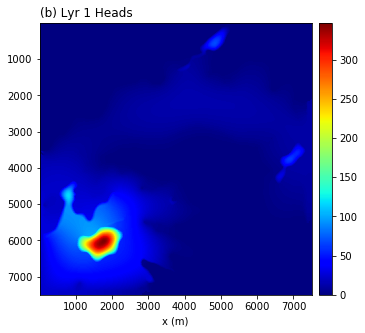

wrote ..\..\RISA_yr6_GIT_ignored_files\Flo_py_wrkspace4\heads.asc


In [84]:
# develop geometry to plot heads as colormap
N = np.array([ncol, nrow, nlay])
dx = np.array([delc, delr, abs(botm)])
Lx = delc*ncol
Ly = delr*nrow
x = np.linspace(0. + dx[0] / 2., Lx - dx[0] / 2., N[0])
y = np.linspace(0. + dx[1] / 2., Ly - dx[1] / 2., N[1])
XX, YY = np.meshgrid(x, y)

# Extract heads data
hds = bf.HeadFile(os.path.join(workspace, '{}.hds'.format(modelname)))
times = hds.get_times() # simulation time, steady state
head = hds.get_data(totim=times[-1])
minv = 0
maxv = head.max()

# Plot em
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
im1 = axes.pcolormesh(XX, YY, head[0], vmin=minv, vmax=maxv, cmap=plt.get_cmap('jet'))
axes.set_title('(b) Lyr 1 Heads', loc='left')
axes.set_xlabel('x (m)')
axes.set_aspect('equal')
axes.axis([XX.min(), XX.max(), YY.max(), YY.min()])
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(axes)
cbar_ax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1, cax=cbar_ax)
plt.show()

# Write the heads layer(s) to a raster file
# export head rasters 
output_raster = os.path.join(workspace, 'heads.asc')   # if there are multiple layers exports based on each layer
grid = ml.modelgrid
flopy.export.utils.export_array(grid, output_raster, head[0])

# Project the output .asc into WGS84 space with manual  ASC header modification 
new_first = ('ncols {}\n'                        # these are the parameters for the .asc file
             'nrows {}\n'
             'xllcorner {}\n'
             'yllcorner {}\n'
             'cellsize {}\n'
             'NODATA_value -999.0'.format(ncol,nrow, xll, yll, np.mean([delc, delr]) ))

with open(os.path.join('.', output_raster), 'r') as fin:   # open file 
    data = fin.read().splitlines(True)
with open(os.path.join('.', output_raster), 'w') as fout:     # delete first line
    fout.writelines(data[6:])
    
with open(os.path.join('.', output_raster), 'r+') as file:                # add in new first line and save file  
    file_data = file.read()
    file. seek(0, 0)
    file. write(new_first + '\n' + file_data)

### Calculate Depth to water


wrote ..\..\RISA_yr6_GIT_ignored_files\Flo_py_wrkspace4\dep2Wat.asc


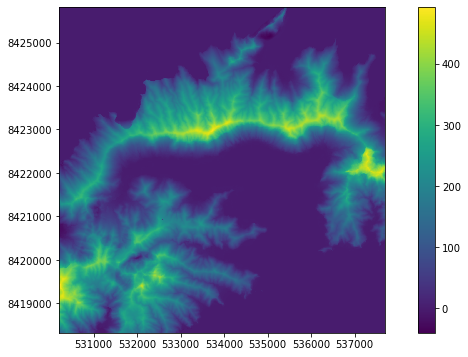

In [85]:
# Super basic depth to water calculation, Currently allows for negative depths (i.e. flooding)
Heads_raw = np.loadtxt(os.path.join(workspace, 'heads.asc'), skiprows=6)   # the 7th row was a no data row for some reason not sure why, if another DEM is used might need to skiprows back to 6
Dep_to_wat = top-Heads_raw

# Write the GIS asc raster from the NP array 
output_raster = os.path.join(workspace, 'dep2Wat.asc')   # if there are multiple layers exports based on each layer
grid = ml.modelgrid
flopy.export.utils.export_array(grid, output_raster, Dep_to_wat)

# Project the output .asc into WGS84 space with manual  ASC header modification 
new_first = ('ncols {}\n'                        # these are the parameters for the .asc file
             'nrows {}\n'
             'xllcorner {}\n'
             'yllcorner {}\n'
             'cellsize {}\n'
             'NODATA_value -999.0'.format(ncol,nrow, xll, yll, np.mean([delc, delr]) ))

with open(os.path.join('.', output_raster), 'r') as fin:   # open file 
    data = fin.read().splitlines(True)
with open(os.path.join('.', output_raster), 'w') as fout:     # delete first line
    fout.writelines(data[6:])
    
with open(os.path.join('.', output_raster), 'r+') as file:                # add in new first line and save file  
    file_data = file.read()
    file. seek(0, 0)
    file. write(new_first + '\n' + file_data)
    
    
if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(Dep_to_wat, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

## Run a basic zonal optimzation calibration

In [86]:
def plot_calibrateo(Howd_we_do):
    
    #Plot the OBS plot if want
    fig = plt.figure(figsize=(4,4))
    plt.title('Observed. vs Simulated.')
    plt.plot(Howd_we_do["Obs_hed_m"], Howd_we_do["Comp_hed_m"], '.')
    #plt.axis('equal')
    #plt.axis('square')
    plt.xlabel("Obs. head [m]")
    plt.ylabel('Sim. head [m]')
    plt.ylim(0,90)
    plt.xlim(0,90)
    plt.plot([0,30,65],[0,30,65], color= "grey")
    plt.tight_layout()
    plt.savefig("cal.pdf")
    plt.show()


def calibrateo(params):
    
    Alluvium_Aua, Alluvium_Fagaalu, Alluvium_minor, Alluvium_Utulei, Alluvium_Vaipito, Alluvium_Vatia, Dikes, Pago_inner_E, Pago_inner_W, Pago_outer, Trachyte, Alluvium_Laulii= params   
    
    # set the  values this cell is set up for optimization
    HK_raster = rastah_zone(os.path.join("..",  'Data/Raw/GIS/Geo_units/v2', 'NPS_simplified_geo_v2.shp'))

    map_dic = {-12:Alluvium_Aua, 
               -14:Alluvium_Fagaalu, 
               -15:Alluvium_minor,
               -13:Alluvium_Utulei,
               -11:Alluvium_Vaipito,
               -10:Alluvium_Vatia,
               -50:Dikes,
               -30:Pago_inner_E,
               -40:Pago_inner_W,
               -20:Pago_outer,
               -60:Trachyte,    
               -16:Alluvium_Laulii}

    for i in map_dic:
        HK_raster = np.where(HK_raster== i, map_dic[i], HK_raster)

    HK_raster = np.where(HK_raster== 0, 7, HK_raster)   # this is for the areas not covered by HK zones, Should not actually maatter at all!
    
    
    
    ############    Now generate the run the new model         
    modelname = 'model_pago_OPT'  
        
    ml = flopy.modflow.Modflow(modelname, version='mf2005', exe_name=exe_name, model_ws=workspace, verbose=False)
    
    discret = flopy.modflow.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol, laycbd=0,
                                       delr=delr, delc=delc, top=top, botm=botm,
                                       nper=nper, perlen=perlen, nstp=nstp)
    
    bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=start_heads)
    lpf = flopy.modflow.ModflowLpf(ml, laytyp=laytyp, hk=HK_raster, vka=vka)
    rch = flopy.modflow.ModflowRch(ml, rech=rch_data)
    oc = flopy.modflow.ModflowOc(ml, stress_period_data=spd)
    pcg = flopy.modflow.ModflowPcg(ml, hclose=1.0e-6, rclose=3.0e-3, mxiter=100, iter1=50)
    drn = flopy.modflow.ModflowDrn(ml, ipakcb=53, print_flows=True, stress_period_data=stress_period_data_drain)  # ipakcb=53, is flag for writing SFR output to cell-by-cell budget (on unit 53)
    wel = flopy.modflow.ModflowWel(model = ml, stress_period_data=stress_period_data_PmpWells)


    # water level observations
    obs_data= []
    for i in range(0,nobs):
        obs = flopy.modflow.HeadObservation(ml, obsname=obsnames[i], layer=layervals[i], row=rowvals[i], column=colvals[i], time_series_data=[[0,obsvals[i]]])
        obs_data.append(obs)
    hob = flopy.modflow.ModflowHob(ml, iuhobsv = 7, hobdry=-999, obs_data = obs_data)        
    
    
    # Run da model 
    ml.write_input()
    ml.run_model(silent=True)


    # post process observations 
    observations = np.loadtxt(os.path.join(workspace, '{}.hob.out'.format(modelname)), skiprows=1, usecols=[0,1])      # this block extracts observation data at each well field and determines what the maximum residual at any of the given points is
    comp_obs = np.ravel(np.split(observations, 2, 1)[0]) # the computed hed values at the obspts
    obs_obs = np.ravel(np.split(observations, 2, 1)[1]) # the observed hed values at the obspts

    # note positive residuals means model is calculating too high negative is model calculates too low 
    residuals = []
    for idx, i in enumerate(observations):   
        r = observations[idx][0]-observations[idx][1]
        residuals.append(r)

    Howd_we_do = pd.DataFrame({"Obs_hed_m":obs_obs,"Comp_hed_m":comp_obs,"Residual_m":residuals})
    # error metrics
    me = np.mean(Howd_we_do.Residual_m)
    mea = np.mean(np.abs(Howd_we_do.Residual_m))
    rmse = np.sqrt(np.mean(Howd_we_do.Residual_m**2))
    
    
    # Plot if want
    plot_calibrateo(Howd_we_do)

    print("Error is - {}".format(rmse))
    print("Params are - {}".format(params))
    return rmse






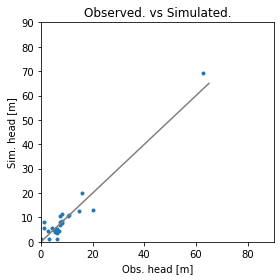

Error is - 3.135045366402255
Params are - [0.7, 16, 16, 0.5, 1.0, 0.5, 0.002, 0.75, 0.17, 0.3, 0.0018, 3.75]


3.135045366402255

In [87]:
# Run once 
# params = [4.6, 13.0, 0.1, 5.0, 2.6, 0.4, 0.3, 0.1, 0.5, 0.6, 0.3]
params = [2.6, 39, 1, 14, 3.7, 1.2, 0.001, 0.37, 0.9, 0.7, 0.3, 1]
params = [0.7, 32, 6.8, 1.9, 1.5, 5.0, 0.001, 1.0, 0.25, 0.2, 0.0015, 2.5] 

#[0.7, 32, 6.8, 1.9, 1.5, 5.0, 0.001, 1.0, 0.25, 0.2, 0.0015, 2.5] 

params = [0.7, 16, 16,  0.5, 1.0, 0.5, 0.002, 0.75, 0.17, 0.3, 0.0018, 3.75] 

calibrateo(params)

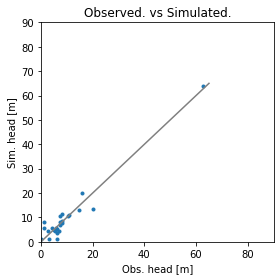

Error is - 2.865666404246623
Params are - [7.00e-01 1.60e+01 1.60e+01 5.00e-01 1.00e+00 5.00e-01 2.30e-03 7.00e-01
 1.70e-01 3.00e-01 1.70e-03 3.75e+00]


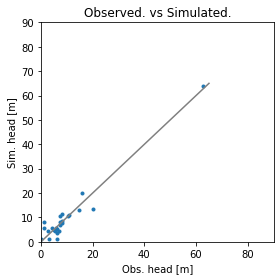

Error is - 2.865456728427772
Params are - [7.35e-01 1.60e+01 1.60e+01 5.00e-01 1.00e+00 5.00e-01 2.30e-03 7.00e-01
 1.70e-01 3.00e-01 1.70e-03 3.75e+00]


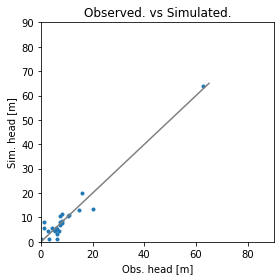

Error is - 2.866643252269425
Params are - [7.00e-01 1.68e+01 1.60e+01 5.00e-01 1.00e+00 5.00e-01 2.30e-03 7.00e-01
 1.70e-01 3.00e-01 1.70e-03 3.75e+00]


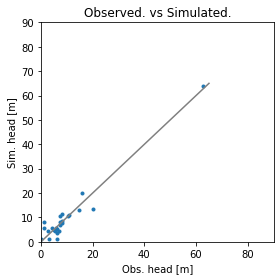

Error is - 2.866374874267886
Params are - [7.00e-01 1.60e+01 1.68e+01 5.00e-01 1.00e+00 5.00e-01 2.30e-03 7.00e-01
 1.70e-01 3.00e-01 1.70e-03 3.75e+00]


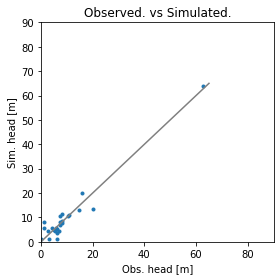

Error is - 2.8654647311581303
Params are - [7.00e-01 1.60e+01 1.60e+01 5.25e-01 1.00e+00 5.00e-01 2.30e-03 7.00e-01
 1.70e-01 3.00e-01 1.70e-03 3.75e+00]


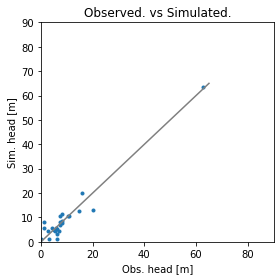

Error is - 2.852705597593722
Params are - [7.00e-01 1.60e+01 1.60e+01 5.00e-01 1.05e+00 5.00e-01 2.30e-03 7.00e-01
 1.70e-01 3.00e-01 1.70e-03 3.75e+00]


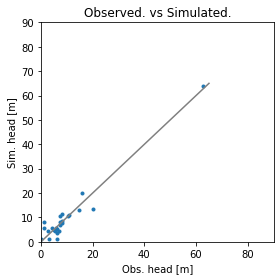

Error is - 2.865713722690681
Params are - [7.00e-01 1.60e+01 1.60e+01 5.00e-01 1.00e+00 5.25e-01 2.30e-03 7.00e-01
 1.70e-01 3.00e-01 1.70e-03 3.75e+00]


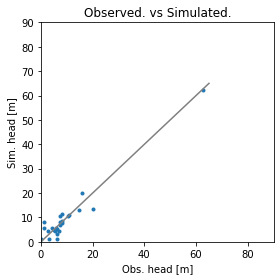

Error is - 2.851340269627784
Params are - [7.000e-01 1.600e+01 1.600e+01 5.000e-01 1.000e+00 5.000e-01 2.415e-03
 7.000e-01 1.700e-01 3.000e-01 1.700e-03 3.750e+00]


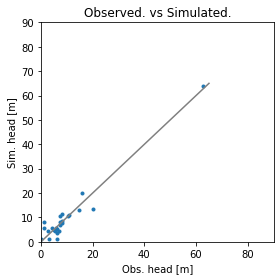

Error is - 2.866493144380186
Params are - [7.00e-01 1.60e+01 1.60e+01 5.00e-01 1.00e+00 5.00e-01 2.30e-03 7.35e-01
 1.70e-01 3.00e-01 1.70e-03 3.75e+00]


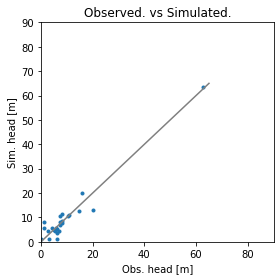

Error is - 2.86112227619471
Params are - [7.000e-01 1.600e+01 1.600e+01 5.000e-01 1.000e+00 5.000e-01 2.300e-03
 7.000e-01 1.785e-01 3.000e-01 1.700e-03 3.750e+00]


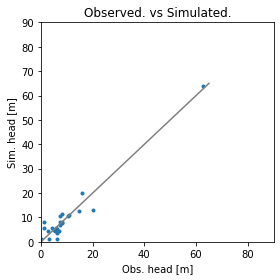

Error is - 2.8633441740553556
Params are - [7.00e-01 1.60e+01 1.60e+01 5.00e-01 1.00e+00 5.00e-01 2.30e-03 7.00e-01
 1.70e-01 3.15e-01 1.70e-03 3.75e+00]


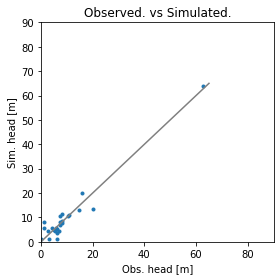

Error is - 2.8652528261304067
Params are - [7.000e-01 1.600e+01 1.600e+01 5.000e-01 1.000e+00 5.000e-01 2.300e-03
 7.000e-01 1.700e-01 3.000e-01 1.785e-03 3.750e+00]


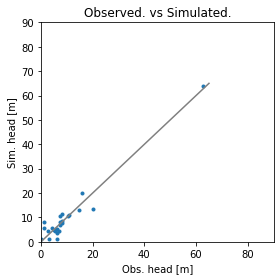

Error is - 2.8658028591258553
Params are - [7.0000e-01 1.6000e+01 1.6000e+01 5.0000e-01 1.0000e+00 5.0000e-01
 2.3000e-03 7.0000e-01 1.7000e-01 3.0000e-01 1.7000e-03 3.9375e+00]


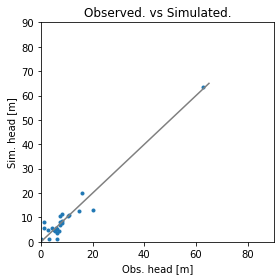

Error is - 2.8564540062703276
Params are - [7.05833333e-01 1.52000000e+01 1.61333333e+01 5.04166667e-01
 1.00833333e+00 5.04166667e-01 2.31916667e-03 7.05833333e-01
 1.71416667e-01 3.02500000e-01 1.71416667e-03 3.78125000e+00]


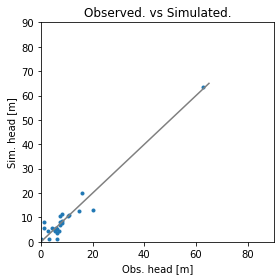

Error is - 2.8548189830430117
Params are - [7.06805556e-01 1.58666667e+01 1.61555556e+01 5.04861111e-01
 1.00972222e+00 5.04861111e-01 2.32236111e-03 6.65972222e-01
 1.71652778e-01 3.02916667e-01 1.71652778e-03 3.78645833e+00]


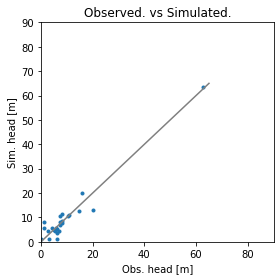

Error is - 2.853342382189476
Params are - [7.07939815e-01 1.58444444e+01 1.52481481e+01 5.05671296e-01
 1.01134259e+00 5.05671296e-01 2.32608796e-03 6.95300926e-01
 1.71928241e-01 3.03402778e-01 1.71928241e-03 3.79253472e+00]


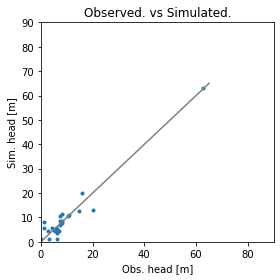

Error is - 2.8523409482215385
Params are - [7.09263117e-01 1.58185185e+01 1.59228395e+01 5.06616512e-01
 1.01323302e+00 5.06616512e-01 2.33043596e-03 6.94517747e-01
 1.72249614e-01 3.03969907e-01 1.72249614e-03 3.58087384e+00]


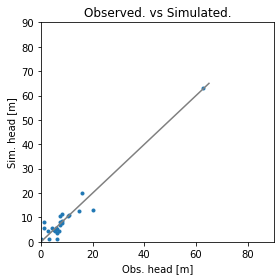

Error is - 2.8506965111674516
Params are - [7.10806970e-01 1.57882716e+01 1.59099794e+01 5.07719264e-01
 1.01543853e+00 4.78552598e-01 2.33550862e-03 6.93604038e-01
 1.72624550e-01 3.04631559e-01 1.72624550e-03 3.74018615e+00]


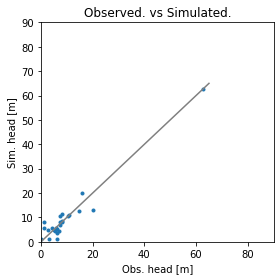

Error is - 2.8473124135198353
Params are - [7.16210455e-01 1.56824074e+01 1.58649691e+01 5.11578897e-01
 1.02315779e+00 4.55328897e-01 2.35326292e-03 6.90406057e-01
 1.73936825e-01 3.06947338e-01 1.73936825e-03 3.73527922e+00]


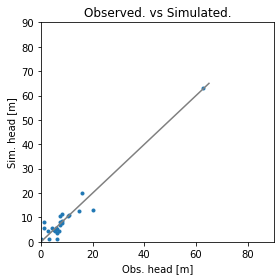

Error is - 2.848522343015869
Params are - [7.13508713e-01 1.57353395e+01 1.58874743e+01 5.09649081e-01
 1.01929816e+00 4.96107414e-01 2.34438577e-03 6.92005048e-01
 1.73280687e-01 3.05789448e-01 1.73280687e-03 3.73773269e+00]


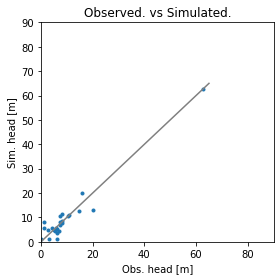

Error is - 2.847772833127314
Params are - [7.15760165e-01 1.56912294e+01 1.58687200e+01 4.82090594e-01
 1.02251452e+00 4.95458649e-01 2.35178340e-03 6.90672556e-01
 1.73827469e-01 3.06754356e-01 1.73827469e-03 3.73568813e+00]


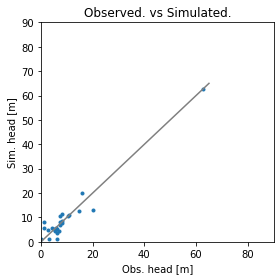

Error is - 2.847308685169407
Params are - [6.77553526e-01 1.56397677e+01 1.58468400e+01 5.04105693e-01
 1.02626694e+00 4.94701758e-01 2.36041397e-03 6.89117981e-01
 1.74465380e-01 3.07880082e-01 1.74465380e-03 3.73330282e+00]


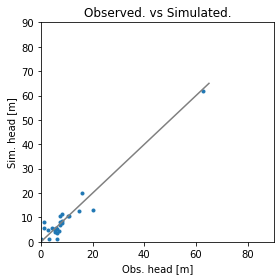

Error is - 2.849664653645077
Params are - [6.48830288e-01 1.54596515e+01 1.57702600e+01 5.06158539e-01
 1.03940041e+00 4.92052637e-01 2.39062095e-03 6.83676972e-01
 1.76698070e-01 3.11820124e-01 1.76698070e-03 3.72495424e+00]


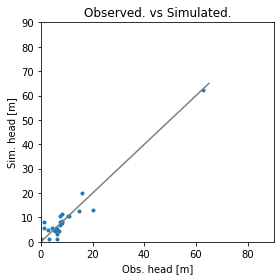

Error is - 2.847674894006091
Params are - [7.08812447e-01 1.55797289e+01 1.58213133e+01 5.04789975e-01
 1.03064476e+00 4.93818717e-01 2.37048296e-03 6.87304312e-01
 1.75209610e-01 3.09193429e-01 1.65292943e-03 3.73051996e+00]


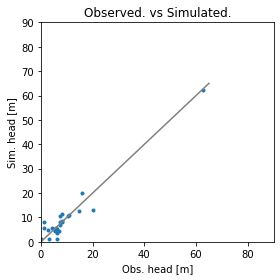

Error is - 2.8472383791979166
Params are - [7.10281188e-01 1.55096838e+01 1.57915322e+01 5.05588304e-01
 1.03575223e+00 4.92788504e-01 2.38223012e-03 6.85188364e-01
 1.76077878e-01 2.93225668e-01 1.73008434e-03 3.72727329e+00]


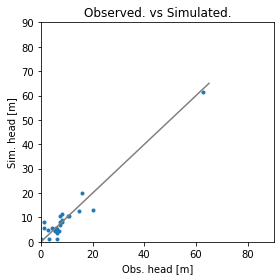

Error is - 2.854844666726087
Params are - [7.15421781e-01 1.52645256e+01 1.56872983e+01 5.08382456e-01
 1.05362834e+00 4.89182755e-01 2.42334518e-03 6.77782545e-01
 1.79116818e-01 2.82338502e-01 1.74512651e-03 3.71590993e+00]


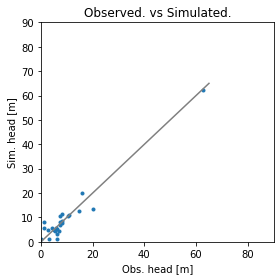

Error is - 2.8438738733766273
Params are - [7.11994719e-01 1.54279644e+01 1.57567876e+01 5.06519688e-01
 1.04171093e+00 4.91586587e-01 2.39593514e-03 6.82719758e-01
 1.67174191e-01 3.07096612e-01 1.73509840e-03 3.72348550e+00]


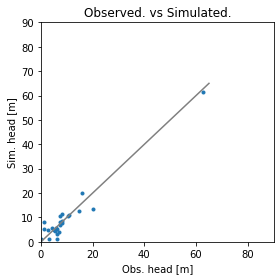

Error is - 2.8471719714025627
Params are - [7.17992078e-01 1.51419466e+01 1.56351814e+01 5.09779532e-01
 1.06256640e+00 4.87379881e-01 2.44390271e-03 6.74079636e-01
 1.61511287e-01 3.10644919e-01 1.75264759e-03 3.71022825e+00]


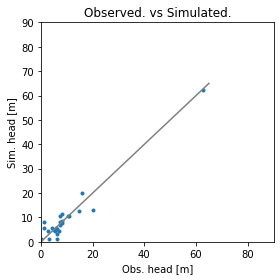

Error is - 2.8471454274119323
Params are - [7.07188283e-01 1.62659585e+01 1.55606966e+01 5.02745192e-01
 1.03894053e+00 4.85323241e-01 2.38956322e-03 6.73034162e-01
 1.73550446e-01 3.05362714e-01 1.72442035e-03 3.68260809e+00]


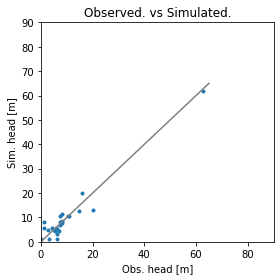

Error is - 2.847950337605937
Params are - [7.06279849e-01 1.56658404e+01 1.54393312e+01 5.01698094e-01
 1.04242136e+00 4.81372485e-01 2.39756912e-03 7.14072263e-01
 1.73630612e-01 3.05353722e-01 1.72337467e-03 3.66009138e+00]


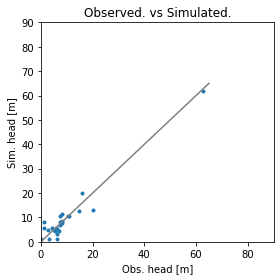

Error is - 2.8491132146595284
Params are - [7.04868929e-01 1.56582953e+01 1.63786025e+01 5.00225709e-01
 1.04598078e+00 4.76512498e-01 2.40575580e-03 6.87872115e-01
 1.73638878e-01 3.05192769e-01 1.72130208e-03 3.63194110e+00]


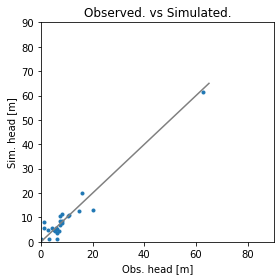

Error is - 2.8543344038804284
Params are - [7.13620232e-01 1.54457890e+01 1.56898511e+01 5.05934623e-01
 1.00665351e+00 4.78269210e-01 2.44946973e-03 6.81151727e-01
 1.76173598e-01 3.09461008e-01 1.74413484e-03 3.65479934e+00]


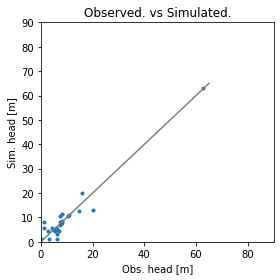

Error is - 2.8476676356482487
Params are - [7.03405058e-01 1.58614472e+01 1.59224628e+01 5.01483656e-01
 1.03916338e+00 4.94567303e-01 2.33736743e-03 6.95287932e-01
 1.71543400e-01 3.02365252e-01 1.71103371e-03 3.72619983e+00]


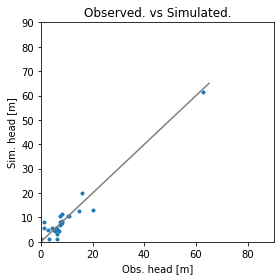

Error is - 2.8509158143099937
Params are - [7.03380771e-01 1.56344252e+01 1.57669488e+01 4.98462635e-01
 1.04774221e+00 4.69644496e-01 2.42018902e-03 6.86762344e-01
 1.73806282e-01 3.05223658e-01 1.71972829e-03 3.84814649e+00]


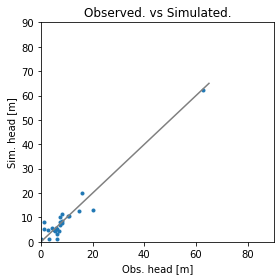

Error is - 2.846986813033094
Params are - [7.13207350e-01 1.53920146e+01 1.56509464e+01 5.04822919e-01
 1.06893227e+00 4.71201758e-01 2.33648981e-03 6.79073815e-01
 1.76690276e-01 3.10064175e-01 1.74551248e-03 3.69537809e+00]


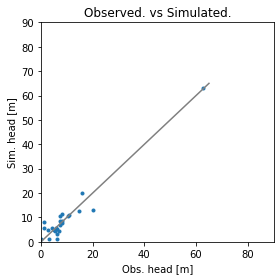

Error is - 2.85145635084164
Params are - [7.11464342e-01 1.57171876e+01 1.58646639e+01 5.07420332e-01
 1.02472174e+00 5.01816805e-01 2.31735093e-03 6.91030049e-01
 1.73364660e-01 3.05647270e-01 1.73008156e-03 3.57177019e+00]


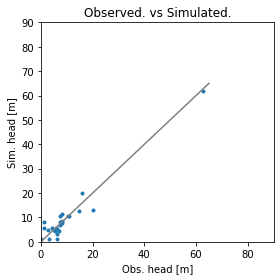

Error is - 2.8474071561517333
Params are - [7.05401664e-01 1.56551158e+01 1.57913776e+01 5.00702059e-01
 1.04198709e+00 4.77687574e-01 2.39447950e-03 6.87829270e-01
 1.73695876e-01 3.05329561e-01 1.72231661e-03 3.77905242e+00]


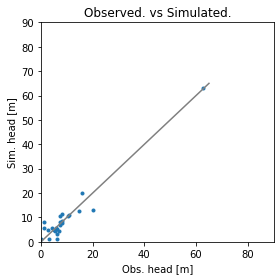

Error is - 2.8488970941461544
Params are - [7.10064974e-01 1.56927876e+01 1.51551394e+01 5.05736650e-01
 1.02581754e+00 4.95144650e-01 2.32990476e-03 6.89913138e-01
 1.73541564e-01 3.05700958e-01 1.72867685e-03 3.81249414e+00]


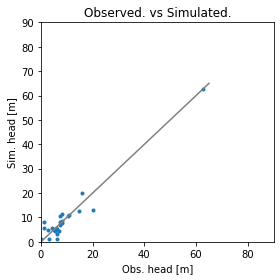

Error is - 2.846819953961832
Params are - [7.08765963e-01 1.56841646e+01 1.54610051e+01 5.04358915e-01
 1.03085835e+00 4.90486612e-01 2.34886752e-03 6.89402882e-01
 1.73565892e-01 3.05573911e-01 1.72683316e-03 3.76735588e+00]


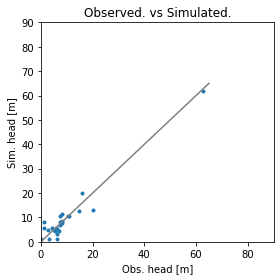

Error is - 2.8479627863588095
Params are - [7.00634732e-01 1.56072143e+01 1.55751894e+01 4.95431584e-01
 1.05442686e+00 4.74612934e-01 2.39202175e-03 6.85346511e-01
 1.73947289e-01 3.05068355e-01 1.71617644e-03 3.71163975e+00]


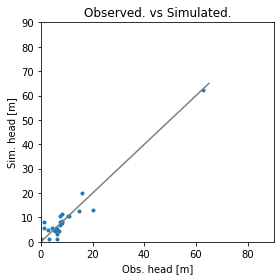

Error is - 2.8465654737280803
Params are - [7.03853227e-01 1.56392456e+01 1.56532606e+01 4.98985958e-01
 1.04564469e+00 4.79986554e-01 2.38011275e-03 6.87011145e-01
 1.73780638e-01 3.05248629e-01 1.72033405e-03 3.71816298e+00]


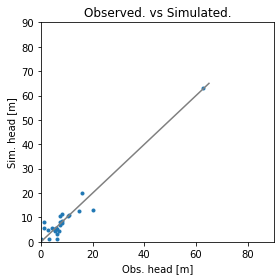

Error is - 2.8476378402652043
Params are - [7.07459158e-01 1.56722809e+01 1.60589873e+01 5.02930547e-01
 1.03184089e+00 4.89116874e-01 2.33592900e-03 6.58769109e-01
 1.73622368e-01 3.05486566e-01 1.72510187e-03 3.79895966e+00]


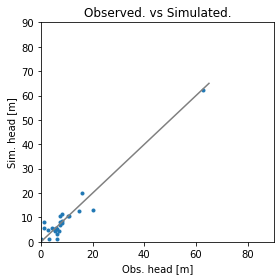

Error is - 2.8463039849466365
Params are - [6.96595341e-01 1.56437338e+01 1.56613098e+01 5.26011373e-01
 1.05330212e+00 4.73973747e-01 2.37907232e-03 6.76851576e-01
 1.73391328e-01 3.03874633e-01 1.70800639e-03 3.73390816e+00]


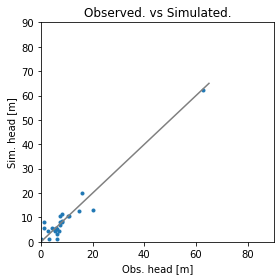

Error is - 2.844823001075334
Params are - [7.01506875e-01 1.57659018e+01 1.56820492e+01 5.06848892e-01
 1.04894810e+00 4.72306184e-01 2.36180432e-03 6.78477697e-01
 1.71706140e-01 3.00549094e-01 1.80253113e-03 3.73964103e+00]


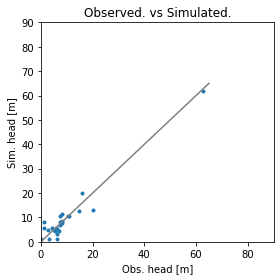

Error is - 2.8479604929772497
Params are - [7.06597900e-01 1.54682592e+01 1.55408308e+01 5.11049417e-01
 1.04206028e+00 4.67847412e-01 2.39899267e-03 6.67692371e-01
 1.75399474e-01 3.07074578e-01 1.75967643e-03 3.74620136e+00]


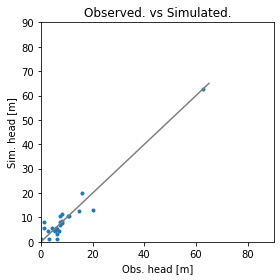

Error is - 2.846216075333002
Params are - [7.04203269e-01 1.57631502e+01 1.58270548e+01 5.03875096e-01
 1.03988760e+00 4.87887330e-01 2.35277374e-03 6.88389041e-01
 1.72507418e-01 3.03542584e-01 1.72319439e-03 3.73120021e+00]


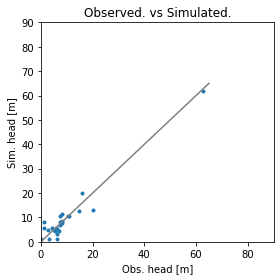

Error is - 2.848295429511818
Params are - [7.02001152e-01 1.56725704e+01 1.53656509e+01 5.09759950e-01
 1.05072389e+00 4.73092917e-01 2.40323856e-03 7.09147848e-01
 1.73134680e-01 3.03629268e-01 1.74529035e-03 3.66214829e+00]


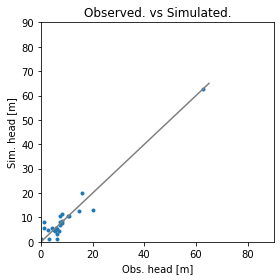

Error is - 2.8461618915605187
Params are - [7.06094657e-01 1.56723533e+01 1.58856532e+01 5.04637898e-01
 1.03656164e+00 4.85110885e-01 2.35275639e-03 6.71363794e-01
 1.73500446e-01 3.05022241e-01 1.73014899e-03 3.76475682e+00]


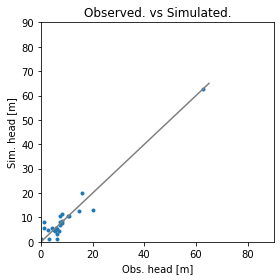

Error is - 2.84660043799347
Params are - [7.04174145e-01 1.56926084e+01 1.56489732e+01 5.12644412e-01
 1.03967344e+00 4.85759436e-01 2.33773421e-03 6.77343441e-01
 1.73028600e-01 3.03735053e-01 1.74938101e-03 3.67967293e+00]


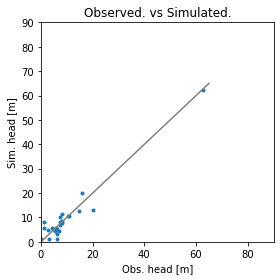

Error is - 2.845918355853649
Params are - [6.91359302e-01 1.56670170e+01 1.55393823e+01 5.01945160e-01
 1.06125535e+00 5.13189869e-01 2.37636266e-03 6.72589552e-01
 1.72636281e-01 3.01581895e-01 1.73399817e-03 3.71417841e+00]


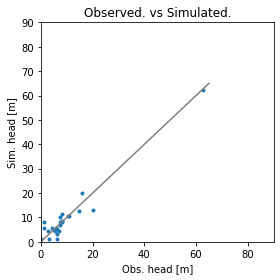

Error is - 2.8449814937660776
Params are - [7.32317194e-01 1.57141983e+01 1.55062685e+01 5.09058275e-01
 1.06397760e+00 4.76898360e-01 2.37186974e-03 6.71122890e-01
 1.71802876e-01 2.99599452e-01 1.72693668e-03 3.71296741e+00]


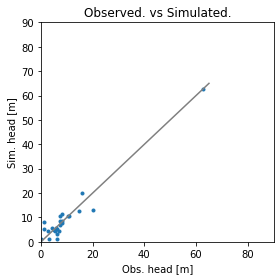

Error is - 2.8451633804465737
Params are - [7.03262200e-01 1.58783680e+01 1.55140323e+01 5.08153992e-01
 1.05919654e+00 4.76163257e-01 2.34832685e-03 6.72708262e-01
 1.69477877e-01 3.15316164e-01 1.74098153e-03 3.71661263e+00]


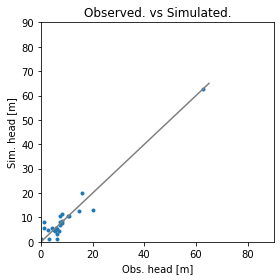

Error is - 2.8452005087471655
Params are - [7.05700757e-01 1.50574949e+01 1.57370906e+01 5.11898571e-01
 1.05938424e+00 4.82101855e-01 2.33412103e-03 6.84808147e-01
 1.71326549e-01 3.04838026e-01 1.74940571e-03 3.76694525e+00]


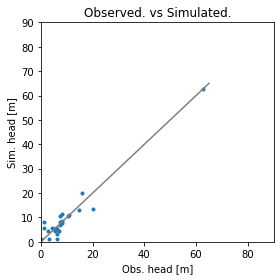

Error is - 2.8461916975998744
Params are - [6.98430591e-01 1.58756854e+01 1.56611981e+01 5.11000119e-01
 1.02780117e+00 4.98040021e-01 2.38679963e-03 6.79724216e-01
 1.67292763e-01 2.99265540e-01 1.72896245e-03 3.76610312e+00]


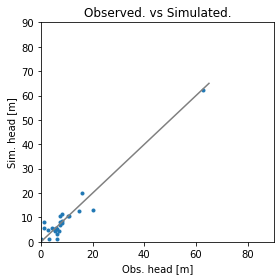

Error is - 2.8446920130944076
Params are - [7.01149417e-01 1.56154556e+01 1.58845049e+01 5.12570991e-01
 1.06536555e+00 4.80014069e-01 2.38074394e-03 6.67782038e-01
 1.69371626e-01 3.02704410e-01 1.74799666e-03 3.69391653e+00]


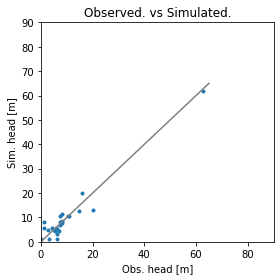

Error is - 2.8460916338687947
Params are - [7.05237113e-01 1.55941530e+01 1.57357921e+01 5.04273257e-01
 1.06083248e+00 4.83783684e-01 2.39904554e-03 6.78247911e-01
 1.69299422e-01 3.04371494e-01 1.72521807e-03 3.78397341e+00]


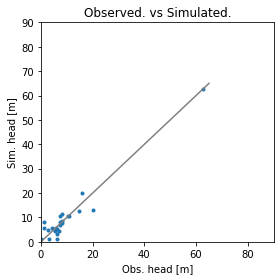

Error is - 2.843515941784112
Params are - [7.05788679e-01 1.56400004e+01 1.57452600e+01 5.18812928e-01
 1.05739253e+00 4.90189421e-01 2.35982247e-03 6.67119668e-01
 1.67800515e-01 3.02711729e-01 1.75507905e-03 3.75645176e+00]


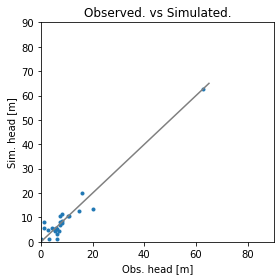

Error is - 2.8433307169437643
Params are - [7.06756405e-01 1.56403777e+01 1.57912596e+01 5.28726413e-01
 1.06326645e+00 4.95290855e-01 2.34967732e-03 6.57173930e-01
 1.64810453e-01 3.01443279e-01 1.77245154e-03 3.77559615e+00]


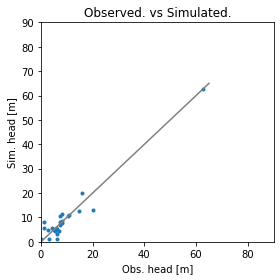

Error is - 2.8438811055490265
Params are - [7.14740075e-01 1.56349528e+01 1.57588691e+01 4.92240019e-01
 1.05139582e+00 4.99755079e-01 2.35596373e-03 6.73999630e-01
 1.66759679e-01 3.03680499e-01 1.77814756e-03 3.74765459e+00]


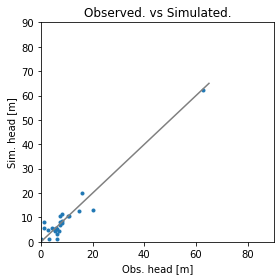

Error is - 2.8431779823662944
Params are - [7.08888282e-01 1.54941701e+01 1.55817598e+01 5.12437117e-01
 1.06672838e+00 4.87819454e-01 2.38279398e-03 6.60063929e-01
 1.66685632e-01 3.04035534e-01 1.77211843e-03 3.75310493e+00]


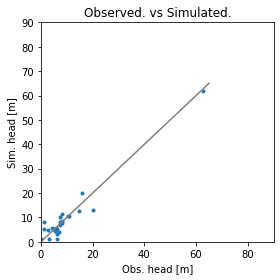

Error is - 2.843486554548819
Params are - [7.11230789e-01 1.53596801e+01 1.54591123e+01 5.16718127e-01
 1.08014876e+00 4.87785516e-01 2.39780409e-03 6.45901373e-01
 1.63774739e-01 3.04282010e-01 1.79658044e-03 3.76405728e+00]


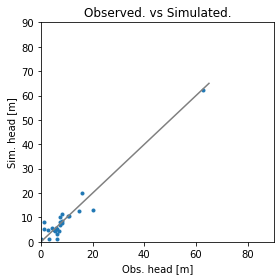

Error is - 2.845260472712457
Params are - [7.16403908e-01 1.53180491e+01 1.57343767e+01 5.05551593e-01
 1.08530268e+00 4.75963335e-01 2.34810047e-03 6.65452040e-01
 1.71799099e-01 3.09107576e-01 1.77354302e-03 3.71603566e+00]


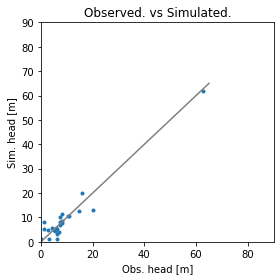

Error is - 2.844013350413418
Params are - [7.10458051e-01 1.54623305e+01 1.54847089e+01 5.12066097e-01
 1.08466572e+00 4.87367880e-01 2.38136773e-03 6.72827170e-01
 1.65307858e-01 3.04031765e-01 1.77958882e-03 3.70926177e+00]


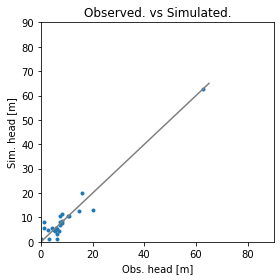

Error is - 2.844494507226781
Params are - [7.12185751e-01 1.55185604e+01 1.55927228e+01 5.13729544e-01
 1.06436708e+00 4.89292447e-01 2.33213227e-03 6.65039596e-01
 1.68843621e-01 3.04625890e-01 1.79358153e-03 3.67759323e+00]


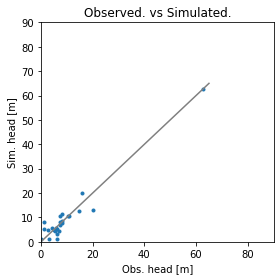

Error is - 2.8432728106206073
Params are - [7.29534637e-01 1.54209536e+01 1.57980227e+01 5.18021705e-01
 1.06446284e+00 4.55903358e-01 2.34744343e-03 6.69439629e-01
 1.64874652e-01 3.07922822e-01 1.79473200e-03 3.74129070e+00]


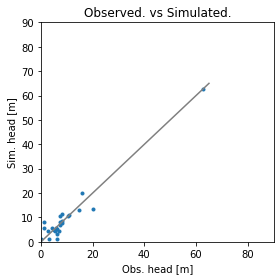

Error is - 2.8450894458848865
Params are - [7.06678486e-01 1.57870723e+01 1.56136359e+01 5.16493624e-01
 1.03694220e+00 4.89786562e-01 2.37559611e-03 6.77241739e-01
 1.64557760e-01 3.00199682e-01 1.75871864e-03 3.74364263e+00]


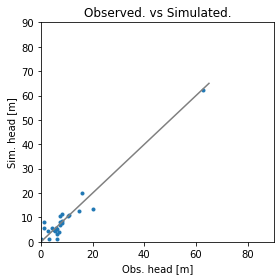

Error is - 2.843267612620411
Params are - [7.17544592e-01 1.61692227e+01 1.55903464e+01 5.10912488e-01
 1.05912029e+00 4.84928827e-01 2.39648807e-03 6.56624564e-01
 1.63902179e-01 3.03696175e-01 1.78440811e-03 3.68884926e+00]


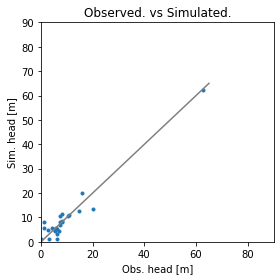

Error is - 2.8425019173891215
Params are - [7.22363548e-01 1.53968254e+01 1.58261236e+01 5.15116817e-01
 1.05929528e+00 4.92328353e-01 2.39030911e-03 6.66043833e-01
 1.64821567e-01 2.91281372e-01 1.80007006e-03 3.73455466e+00]


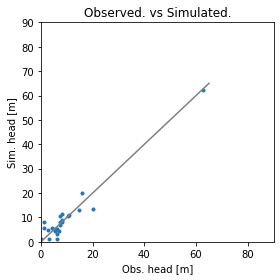

Error is - 2.845189516082516
Params are - [7.31914221e-01 1.51560541e+01 1.59821692e+01 5.18598229e-01
 1.05934465e+00 5.00410902e-01 2.41130024e-03 6.62711619e-01
 1.62493413e-01 2.79263975e-01 1.82961433e-03 3.74352567e+00]


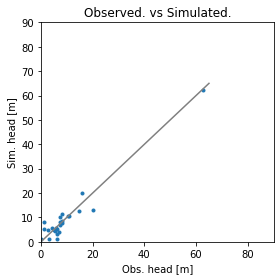

Error is - 2.844718517982603
Params are - [7.21561439e-01 1.54230799e+01 1.57619346e+01 5.06547717e-01
 1.08527514e+00 4.79128680e-01 2.36549202e-03 6.59644038e-01
 1.69785652e-01 3.04911469e-01 1.78922485e-03 3.70601000e+00]


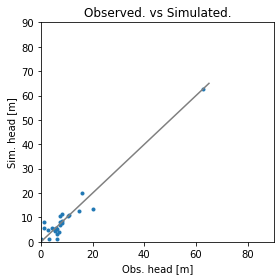

Error is - 2.842489251338304
Params are - [6.94130104e-01 1.54474342e+01 1.59119130e+01 5.13564639e-01
 1.06178933e+00 4.92388602e-01 2.36815544e-03 6.63849746e-01
 1.62204333e-01 3.06397035e-01 1.83138817e-03 3.73552565e+00]


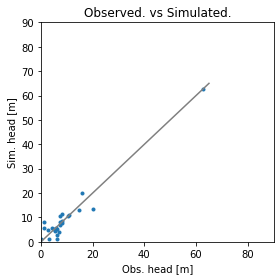

Error is - 2.8442158083792655
Params are - [6.75036560e-01 1.53140521e+01 1.61147353e+01 5.15817821e-01
 1.06069520e+00 5.00133723e-01 2.36629829e-03 6.60213174e-01
 1.57405061e-01 3.09795826e-01 1.88361392e-03 3.74680477e+00]


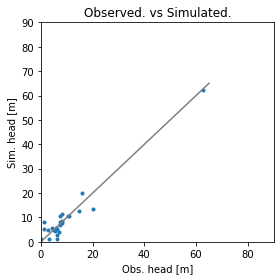

Error is - 2.8425237861876114
Params are - [7.23710961e-01 1.53426528e+01 1.57744430e+01 5.16893314e-01
 1.07895903e+00 5.00327848e-01 2.37927937e-03 6.54056947e-01
 1.60717434e-01 3.06422050e-01 1.76060322e-03 3.70816613e+00]


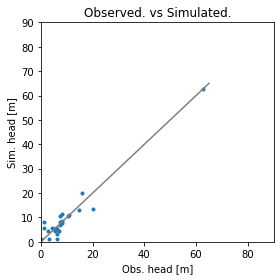

Error is - 2.8451010495537727
Params are - [7.04014652e-01 1.56720701e+01 1.56966423e+01 5.18918755e-01
 1.04157931e+00 4.97038547e-01 2.37788957e-03 6.71959423e-01
 1.61126552e-01 3.02311438e-01 1.76913924e-03 3.74215652e+00]


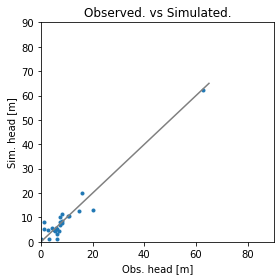

Error is - 2.8434398378047323
Params are - [7.17174742e-01 1.54853275e+01 1.57456115e+01 5.09640476e-01
 1.07435118e+00 4.83606147e-01 2.36859141e-03 6.62722885e-01
 1.67620877e-01 3.04261461e-01 1.78420344e-03 3.71504663e+00]


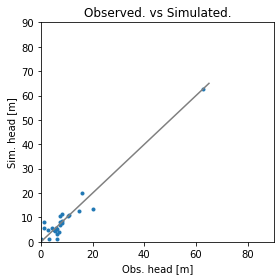

Error is - 2.8423965291597852
Params are - [7.27097561e-01 1.54580064e+01 1.55509231e+01 5.12407061e-01
 1.06298651e+00 4.96751837e-01 2.36061222e-03 6.62978232e-01
 1.61248787e-01 3.04778006e-01 1.81640189e-03 3.75777167e+00]


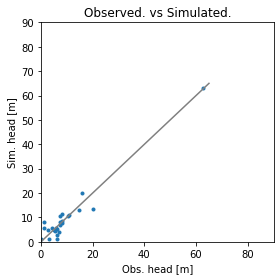

Error is - 2.8449994325803267
Params are - [7.40071633e-01 1.53792818e+01 1.53841322e+01 5.12325097e-01
 1.06179699e+00 5.05120722e-01 2.35054636e-03 6.60576329e-01
 1.57187368e-01 3.05814804e-01 1.85060451e-03 3.78969924e+00]


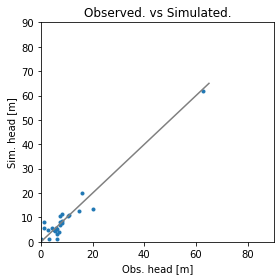

Error is - 2.843534740697876
Params are - [7.18546529e-01 1.55448093e+01 1.58357386e+01 5.11028095e-01
 1.06375488e+00 4.88716691e-01 2.41397055e-03 6.65377113e-01
 1.60510986e-01 3.02881878e-01 1.77462041e-03 3.78745804e+00]


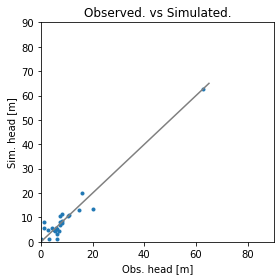

Error is - 2.844478133637085
Params are - [7.21622308e-01 1.56147857e+01 1.60022574e+01 5.12518542e-01
 1.03997111e+00 4.90866060e-01 2.37016890e-03 6.56347863e-01
 1.63247270e-01 3.03284356e-01 1.78778505e-03 3.76882222e+00]


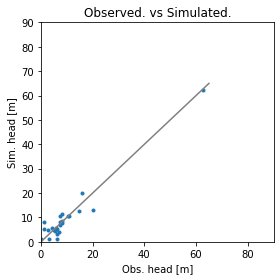

Error is - 2.84293778564996
Params are - [7.13249115e-01 1.55004443e+01 1.56140960e+01 5.12179208e-01
 1.07349206e+00 4.88242425e-01 2.37856802e-03 6.68707343e-01
 1.64792711e-01 3.03844913e-01 1.78163788e-03 3.72415188e+00]


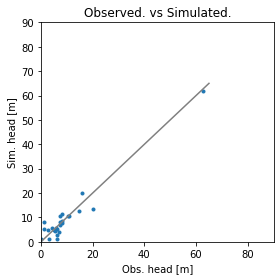

Error is - 2.84277925011093
Params are - [7.17091791e-01 1.54197453e+01 1.57039684e+01 5.35667818e-01
 1.07692371e+00 4.76560085e-01 2.39934028e-03 6.54293354e-01
 1.61467622e-01 3.03663024e-01 1.78980803e-03 3.72651228e+00]


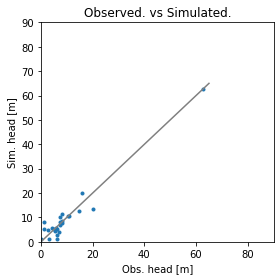

Error is - 2.8424101771653225
Params are - [7.20686659e-01 1.56253638e+01 1.56972467e+01 5.26246170e-01
 1.09247739e+00 4.82224159e-01 2.35993639e-03 6.40835493e-01
 1.60102014e-01 2.99674646e-01 1.84197547e-03 3.75118583e+00]


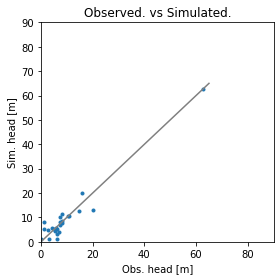

Error is - 2.8436299306789734
Params are - [7.14491538e-01 1.55219447e+01 1.55952138e+01 5.24274109e-01
 1.07522053e+00 4.84011967e-01 2.33289529e-03 6.54087868e-01
 1.66697058e-01 3.03354841e-01 1.81367930e-03 3.68116792e+00]


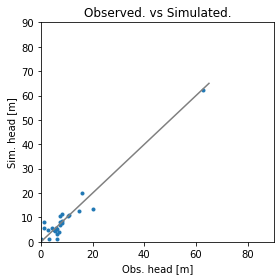

Error is - 2.842413709017686
Params are - [7.17532781e-01 1.55390931e+01 1.57756074e+01 5.14339599e-01
 1.06662129e+00 4.87540510e-01 2.39370174e-03 6.62554801e-01
 1.62057504e-01 3.03000119e-01 1.78438513e-03 3.76088551e+00]


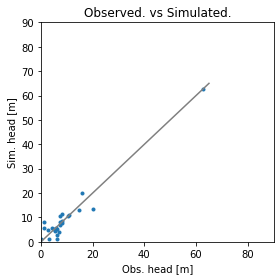

Error is - 2.8426920730294394
Params are - [7.15922997e-01 1.55903874e+01 1.56903401e+01 5.26444915e-01
 1.06333591e+00 4.89778239e-01 2.38245949e-03 6.56714082e-01
 1.58659938e-01 3.01765034e-01 1.80412655e-03 3.76121915e+00]


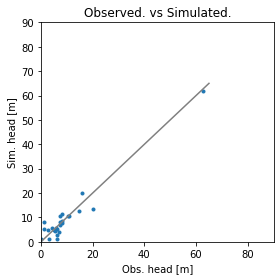

Error is - 2.842958688902351
Params are - [7.27869100e-01 1.54270054e+01 1.56278721e+01 5.06978729e-01
 1.07443222e+00 4.77174762e-01 2.40683727e-03 6.62186395e-01
 1.60445276e-01 3.04636842e-01 1.82115761e-03 3.69827346e+00]


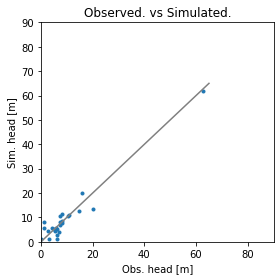

Error is - 2.8435502370025145
Params are - [7.04813278e-01 1.56474382e+01 1.55927505e+01 5.15842941e-01
 1.07489740e+00 5.20107492e-01 2.41897014e-03 6.48711824e-01
 1.59642847e-01 2.97609636e-01 1.80328142e-03 3.72540936e+00]


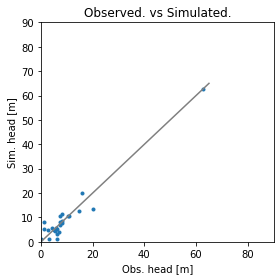

Error is - 2.842329020115418
Params are - [7.23354297e-01 1.54775747e+01 1.57467047e+01 5.17477014e-01
 1.06707148e+00 4.71954392e-01 2.36532510e-03 6.64257678e-01
 1.63566701e-01 3.05344526e-01 1.79686936e-03 3.73732037e+00]


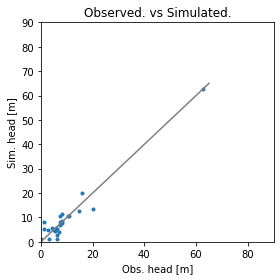

Error is - 2.84178737433683
Params are - [7.17771608e-01 1.47838944e+01 1.58264866e+01 5.24046245e-01
 1.08156514e+00 4.88919618e-01 2.36473167e-03 6.62799075e-01
 1.60559408e-01 3.02111008e-01 1.81568219e-03 3.78592932e+00]


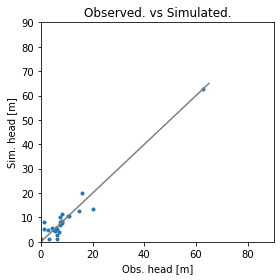

Error is - 2.842718090318944
Params are - [7.17885116e-01 1.40912303e+01 1.59445567e+01 5.30613124e-01
 1.09278756e+00 4.90915014e-01 2.34885347e-03 6.65886330e-01
 1.58888022e-01 3.01318425e-01 1.83131923e-03 3.83446935e+00]


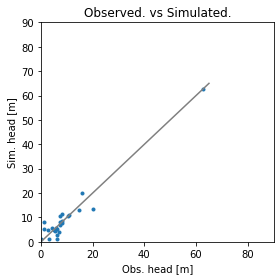

Error is - 2.842316064429101
Params are - [7.27908472e-01 1.53405678e+01 1.58758610e+01 5.24456472e-01
 1.07642985e+00 4.86212351e-01 2.37541538e-03 6.59815567e-01
 1.56754917e-01 3.01450895e-01 1.83523250e-03 3.72714439e+00]


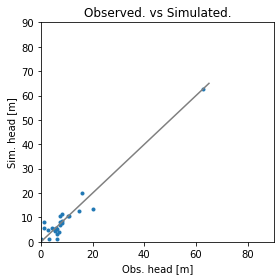

Error is - 2.8433020447344575
Params are - [7.08934216e-01 1.53933262e+01 1.58710802e+01 5.32827816e-01
 1.06905895e+00 4.98363308e-01 2.34613510e-03 6.57297963e-01
 1.62380213e-01 3.00318596e-01 1.78853913e-03 3.78678768e+00]


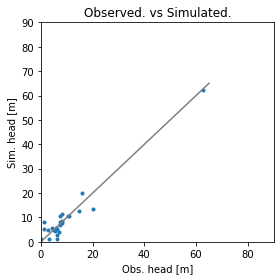

Error is - 2.842119394621226
Params are - [7.23135379e-01 1.54185856e+01 1.56886741e+01 5.13441001e-01
 1.07308890e+00 4.82471898e-01 2.39166173e-03 6.60964287e-01
 1.60929010e-01 3.03557281e-01 1.81300299e-03 3.72040201e+00]


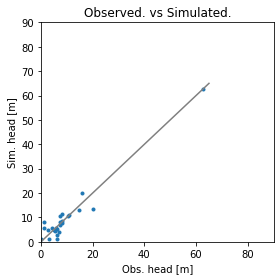

Error is - 2.842375258898893
Params are - [7.25201911e-01 1.53062442e+01 1.58972859e+01 5.27837636e-01
 1.06993191e+00 4.86333891e-01 2.37658663e-03 6.49486506e-01
 1.57388828e-01 3.01062587e-01 1.83328638e-03 3.76028428e+00]


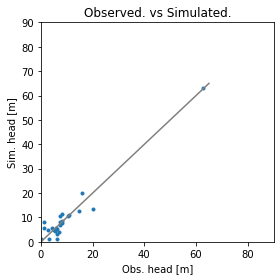

Error is - 2.843380206379275
Params are - [7.22710922e-01 1.53680264e+01 1.58396331e+01 5.03043996e-01
 1.06533496e+00 4.99645198e-01 2.35202210e-03 6.63099354e-01
 1.60034118e-01 3.00811069e-01 1.83236262e-03 3.76355255e+00]


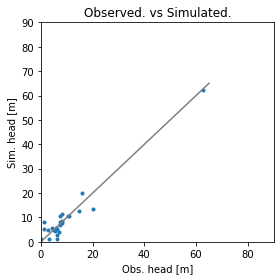

Error is - 2.8419741493204667
Params are - [7.18496574e-01 1.54068155e+01 1.57378846e+01 5.27511862e-01
 1.07402652e+00 4.82331363e-01 2.38751074e-03 6.56494854e-01
 1.61109246e-01 3.02950035e-01 1.80044668e-03 3.73577235e+00]


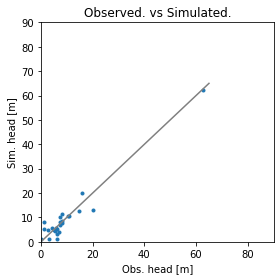

Error is - 2.8421782255350925
Params are - [7.24308645e-01 1.51667889e+01 1.58611855e+01 5.12444723e-01
 1.08070453e+00 4.85185898e-01 2.36974477e-03 6.60642088e-01
 1.63250021e-01 3.02906559e-01 1.81743080e-03 3.72460455e+00]


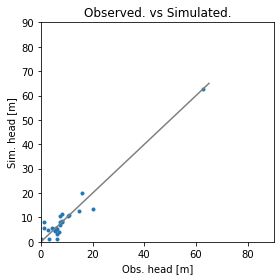

Error is - 2.8418184331675524
Params are - [7.16620295e-01 1.53852129e+01 1.57915397e+01 5.21254893e-01
 1.06537232e+00 4.72112631e-01 2.37133578e-03 6.64396747e-01
 1.61614622e-01 2.97663628e-01 1.87042538e-03 3.78039730e+00]


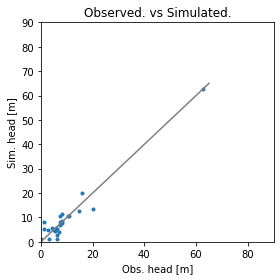

Error is - 2.8433633518012913
Params are - [7.17010500e-01 1.53291049e+01 1.57340951e+01 5.24054403e-01
 1.08604891e+00 4.76742838e-01 2.35714382e-03 6.52135346e-01
 1.56975998e-01 3.13868016e-01 1.84268443e-03 3.76164921e+00]


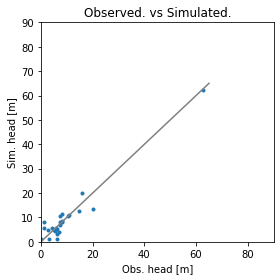

Error is - 2.841794387713887
Params are - [7.21025286e-01 1.53798953e+01 1.58031165e+01 5.17351213e-01
 1.06598369e+00 4.88431975e-01 2.38201779e-03 6.62566711e-01
 1.62860175e-01 2.96928033e-01 1.81072365e-03 3.74132830e+00]


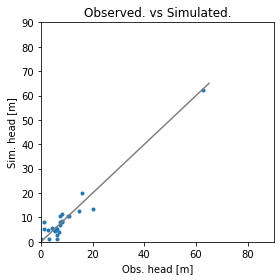

Error is - 2.841661901803414
Params are - [7.49726473e-01 1.52672396e+01 1.56301729e+01 5.26237676e-01
 1.08425392e+00 4.76023152e-01 2.38160788e-03 6.54115594e-01
 1.59702540e-01 2.97174185e-01 1.80792223e-03 3.76164533e+00]


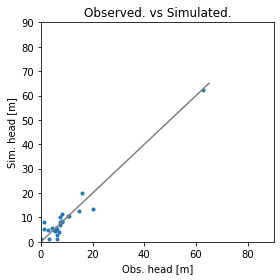

Error is - 2.842252634146195
Params are - [7.77524658e-01 1.51771423e+01 1.54893029e+01 5.32574194e-01
 1.09548622e+00 4.67840426e-01 2.38833410e-03 6.49248518e-01
 1.58451643e-01 2.92562761e-01 1.79618926e-03 3.77470517e+00]


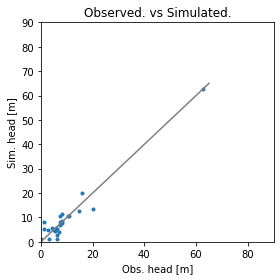

Error is - 2.842106928494036
Params are - [7.31689412e-01 1.51302717e+01 1.57422395e+01 5.27445729e-01
 1.08236073e+00 4.78951684e-01 2.35404594e-03 6.54004004e-01
 1.59456874e-01 2.99600112e-01 1.85884812e-03 3.73641210e+00]


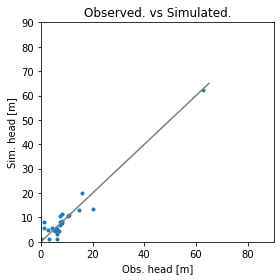

Error is - 2.842379628051663
Params are - [7.30369327e-01 1.49614857e+01 1.58280990e+01 5.15739084e-01
 1.05481852e+00 4.83722622e-01 2.38682954e-03 6.77918064e-01
 1.61304841e-01 3.02913163e-01 1.80406989e-03 3.74364950e+00]


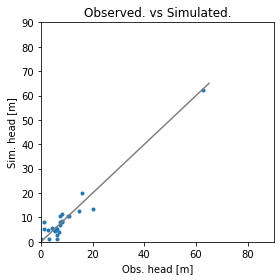

Error is - 2.842122342452711
Params are - [7.24503719e-01 1.50460897e+01 1.60206185e+01 5.30133530e-01
 1.08294808e+00 4.67023408e-01 2.39052327e-03 6.58265298e-01
 1.60167410e-01 2.97498996e-01 1.82758814e-03 3.73470996e+00]


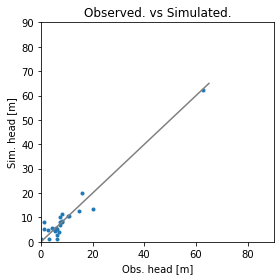

Error is - 2.8424383568800824
Params are - [7.20254352e-01 1.55567110e+01 1.57755293e+01 5.29200582e-01
 1.09580432e+00 4.77269421e-01 2.36492157e-03 6.40050004e-01
 1.59921785e-01 2.98461477e-01 1.84383984e-03 3.74734221e+00]


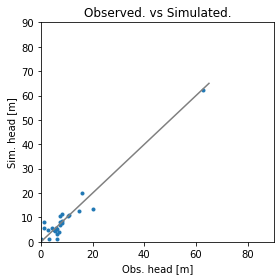

Error is - 2.841480603725118
Params are - [7.27840583e-01 1.51102920e+01 1.58149565e+01 5.19104459e-01
 1.06506497e+00 4.82109322e-01 2.38135255e-03 6.68451049e-01
 1.60959077e-01 3.01800242e-01 1.81401238e-03 3.74457268e+00]


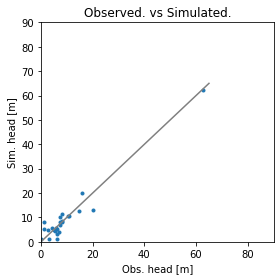

Error is - 2.8424991470283
Params are - [7.25861546e-01 1.51792938e+01 1.56926208e+01 5.15646500e-01
 1.07987978e+00 4.73954058e-01 2.37595880e-03 6.71642319e-01
 1.64432839e-01 3.00434997e-01 1.81141102e-03 3.72808883e+00]


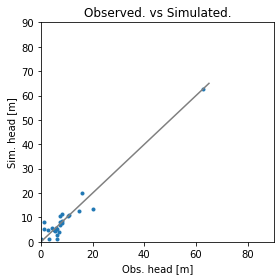

Error is - 2.8415549519037615
Params are - [7.25366820e-01 1.52745066e+01 1.58461196e+01 5.24789852e-01
 1.07241888e+00 4.83238933e-01 2.37642967e-03 6.55025459e-01
 1.59149831e-01 3.00905689e-01 1.82781754e-03 3.75223542e+00]


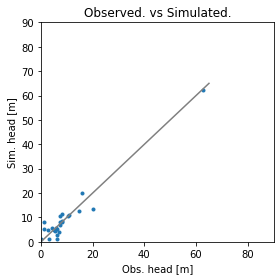

Error is - 2.841469814187839
Params are - [7.28044580e-01 1.49741186e+01 1.58597712e+01 5.27225929e-01
 1.08363145e+00 4.90214314e-01 2.38907109e-03 6.55332445e-01
 1.57518820e-01 2.95413251e-01 1.85298608e-03 3.75353858e+00]


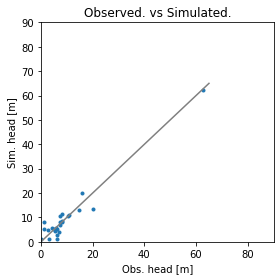

Error is - 2.842660021391768
Params are - [7.30389721e-01 1.47223905e+01 1.59163044e+01 5.32100386e-01
 1.09191143e+00 4.99344275e-01 2.40094408e-03 6.50869828e-01
 1.54494880e-01 2.90447614e-01 1.88104444e-03 3.76164769e+00]


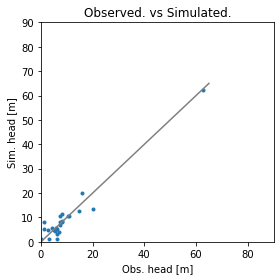

Error is - 2.841990739646587
Params are - [7.23513091e-01 1.50500507e+01 1.57279332e+01 5.20708047e-01
 1.07547334e+00 4.76623348e-01 2.38125677e-03 6.59027368e-01
 1.64457922e-01 2.98300609e-01 1.81758186e-03 3.76811359e+00]


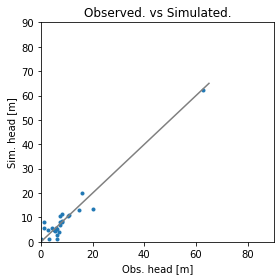

Error is - 2.8422203854128987
Params are - [7.26980325e-01 1.52043732e+01 1.57204000e+01 5.34097016e-01
 1.07032679e+00 4.76222709e-01 2.38884605e-03 6.57931727e-01
 1.58164135e-01 2.96077286e-01 1.83540874e-03 3.77790494e+00]


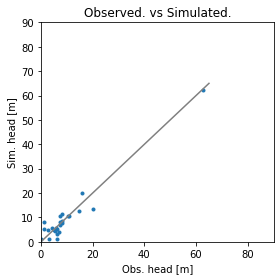

Error is - 2.8417973651956547
Params are - [7.24976565e-01 1.51761850e+01 1.58259891e+01 5.17857797e-01
 1.07811010e+00 4.82945101e-01 2.37452009e-03 6.59964498e-01
 1.61978549e-01 3.01199241e-01 1.82192528e-03 3.73792965e+00]


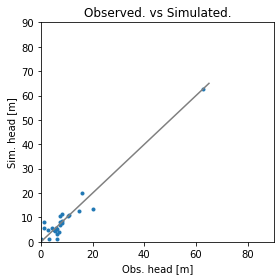

Error is - 2.841765880469342
Params are - [7.26864059e-01 1.53467550e+01 1.55285287e+01 5.14362254e-01
 1.06727691e+00 4.97038815e-01 2.36540035e-03 6.60591717e-01
 1.61548602e-01 3.02101556e-01 1.82430760e-03 3.76833614e+00]


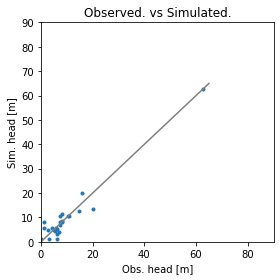

Error is - 2.8417306907371698
Params are - [7.28853845e-01 1.49622873e+01 1.58337823e+01 5.31208325e-01
 1.07616743e+00 4.84018144e-01 2.35988499e-03 6.57830633e-01
 1.60890267e-01 2.95800651e-01 1.84077684e-03 3.79063311e+00]


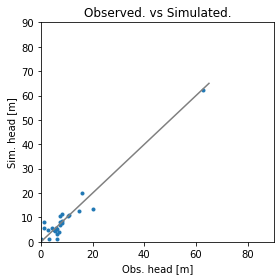

Error is - 2.8421600339068385
Params are - [7.19827217e-01 1.52226038e+01 1.57954740e+01 5.17830696e-01
 1.06586338e+00 4.88382768e-01 2.39847395e-03 6.65428688e-01
 1.62601302e-01 2.99124576e-01 1.79191983e-03 3.78365986e+00]


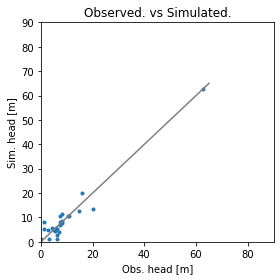

Error is - 2.841621399290506
Params are - [7.28723864e-01 1.51533547e+01 1.57555481e+01 5.25041971e-01
 1.07823639e+00 4.81309455e-01 2.36515295e-03 6.56860175e-01
 1.60242981e-01 2.99481228e-01 1.84211605e-03 3.74822404e+00]


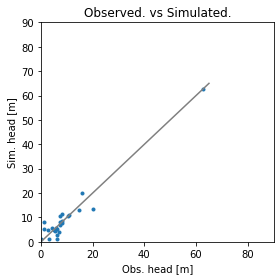

Error is - 2.842800751703747
Params are - [7.28872001e-01 1.53200421e+01 1.58143827e+01 5.25290699e-01
 1.07321128e+00 4.91492122e-01 2.36857915e-03 6.60044125e-01
 1.56897764e-01 3.00620850e-01 1.83727512e-03 3.74864344e+00]


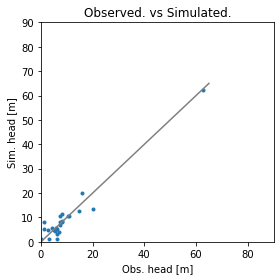

Error is - 2.8415724252922234
Params are - [7.24852818e-01 1.51175486e+01 1.57495456e+01 5.21853710e-01
 1.07490782e+00 4.80340542e-01 2.37808736e-03 6.59281557e-01
 1.62567883e-01 2.98880669e-01 1.82250518e-03 3.76324606e+00]


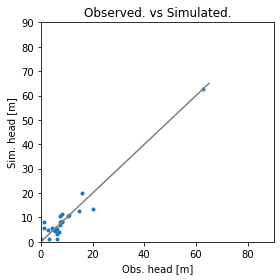

Error is - 2.841774079188136
Params are - [7.34947892e-01 1.49150661e+01 1.58063749e+01 5.17543858e-01
 1.07480498e+00 4.85452303e-01 2.36075462e-03 6.63041089e-01
 1.60489546e-01 2.95293195e-01 1.85808672e-03 3.78556364e+00]


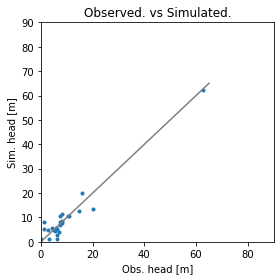

Error is - 2.841566267118315
Params are - [7.39878770e-01 1.48583110e+01 1.57551923e+01 5.23182322e-01
 1.08503129e+00 4.97894315e-01 2.37516606e-03 6.54913254e-01
 1.59796658e-01 3.00184530e-01 1.78605158e-03 3.74179975e+00]


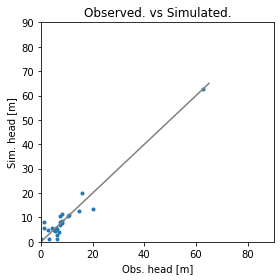

Error is - 2.8414442077158277
Params are - [7.34006202e-01 1.50143599e+01 1.57089434e+01 5.27466839e-01
 1.07344705e+00 4.89553380e-01 2.37208941e-03 6.58503629e-01
 1.59069082e-01 2.96479799e-01 1.82857272e-03 3.78491241e+00]


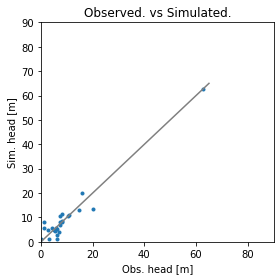

Error is - 2.842617397793665
Params are - [7.38521020e-01 1.49334474e+01 1.56504206e+01 5.32271360e-01
 1.07111553e+00 4.92857520e-01 2.37087407e-03 6.57773194e-01
 1.57614348e-01 2.94120078e-01 1.83189644e-03 3.80840380e+00]


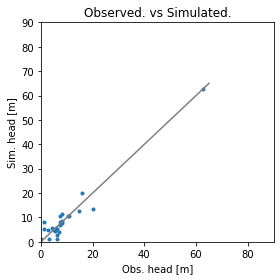

Error is - 2.8417418785869306
Params are - [7.40120967e-01 1.47497271e+01 1.57161206e+01 5.29659360e-01
 1.08681735e+00 4.84253407e-01 2.36293698e-03 6.55224235e-01
 1.57555607e-01 3.00676302e-01 1.84274920e-03 3.78877778e+00]


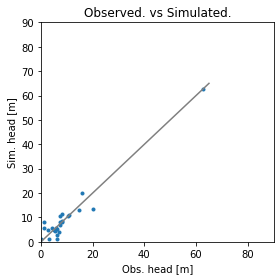

Error is - 2.8415110114590956
Params are - [7.47099538e-01 1.53400333e+01 1.56743561e+01 5.23899847e-01
 1.07211127e+00 4.82988062e-01 2.37992398e-03 6.53729398e-01
 1.59355741e-01 2.95254208e-01 1.84230183e-03 3.74465150e+00]


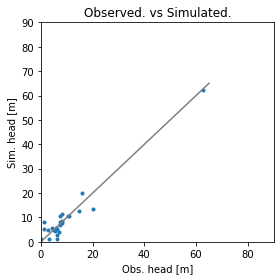

Error is - 2.8416190981941223
Params are - [7.31948527e-01 1.52796895e+01 1.56724647e+01 5.31461566e-01
 1.07842247e+00 4.86044670e-01 2.38709592e-03 6.51935435e-01
 1.59236635e-01 3.02065523e-01 1.79726648e-03 3.73819849e+00]


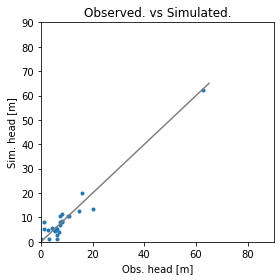

Error is - 2.8416768237492773
Params are - [7.40879772e-01 1.48368230e+01 1.59743001e+01 5.37493055e-01
 1.08780814e+00 4.72625801e-01 2.38606613e-03 6.52942093e-01
 1.57792251e-01 2.95251157e-01 1.82653875e-03 3.75040305e+00]


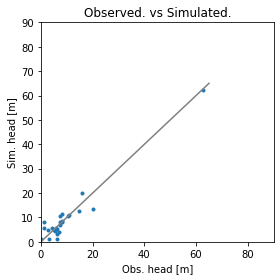

Error is - 2.8418526131162682
Params are - [7.27749332e-01 1.54483670e+01 1.58297382e+01 5.23501565e-01
 1.06843283e+00 4.83473274e-01 2.39238435e-03 6.57929219e-01
 1.61824687e-01 2.95772221e-01 1.80539541e-03 3.72356562e+00]


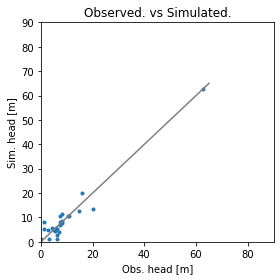

Error is - 2.841424048229005
Params are - [7.37028058e-01 1.49243870e+01 1.57445250e+01 5.28119911e-01
 1.08222122e+00 4.84058374e-01 2.37029882e-03 6.55900481e-01
 1.58622877e-01 2.99450281e-01 1.83341075e-03 3.77247474e+00]


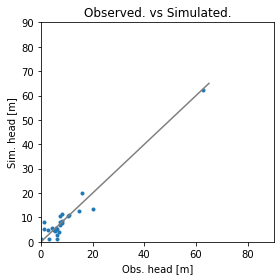

Error is - 2.841908587924798
Params are - [7.40378822e-01 1.52294900e+01 1.56972003e+01 5.21437864e-01
 1.08009172e+00 4.83715242e-01 2.39717198e-03 6.55001129e-01
 1.58112129e-01 3.01256143e-01 1.80614009e-03 3.71868390e+00]


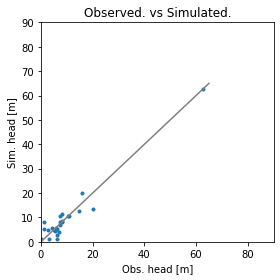

Error is - 2.8414156216615716
Params are - [7.31735090e-01 1.50290880e+01 1.57996368e+01 5.28765710e-01
 1.07714850e+00 4.83942419e-01 2.36920674e-03 6.57123257e-01
 1.60195733e-01 2.97164524e-01 1.83211765e-03 3.77264581e+00]


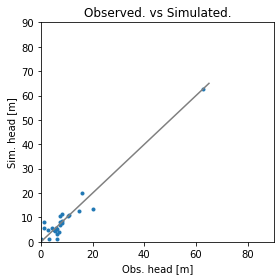

Error is - 2.841716429674961
Params are - [7.26828782e-01 1.53869984e+01 1.55275719e+01 5.13698576e-01
 1.06667440e+00 4.96993688e-01 2.36818094e-03 6.60586529e-01
 1.61610725e-01 3.02124532e-01 1.82130799e-03 3.76262108e+00]


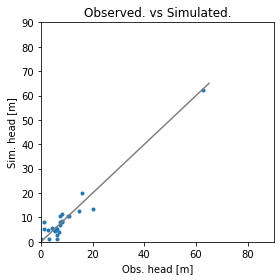

Error is - 2.841418923421206
Params are - [7.37367025e-01 1.49743669e+01 1.58626181e+01 5.31544436e-01
 1.08252470e+00 4.78717773e-01 2.38159483e-03 6.54853202e-01
 1.58746870e-01 2.96969500e-01 1.82523106e-03 3.75345756e+00]


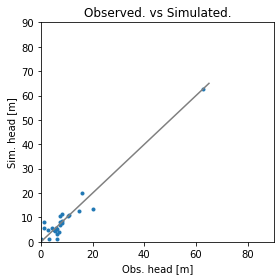

Error is - 2.8414021630263875
Params are - [7.15922172e-01 1.49077698e+01 1.59104400e+01 5.25838416e-01
 1.06994042e+00 4.94045441e-01 2.37263702e-03 6.59535962e-01
 1.59541158e-01 3.00167389e-01 1.84280932e-03 3.75001418e+00]


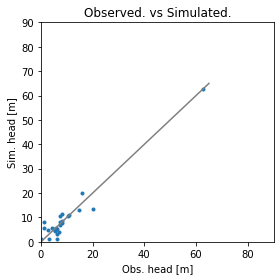

Error is - 2.842513434546163
Params are - [6.99020022e-01 1.47280348e+01 1.60505735e+01 5.25638786e-01
 1.06278366e+00 5.03056586e-01 2.36815158e-03 6.62246147e-01
 1.59460468e-01 3.01663991e-01 1.86025286e-03 3.74419861e+00]


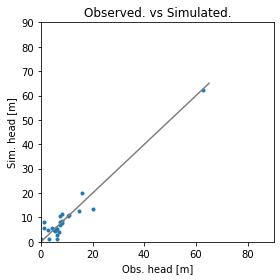

Error is - 2.8413100770062942
Params are - [7.34791167e-01 1.49807238e+01 1.58108801e+01 5.27166861e-01
 1.07457528e+00 4.90881802e-01 2.39033930e-03 6.57237346e-01
 1.58883746e-01 2.97974706e-01 1.80873105e-03 3.76373382e+00]


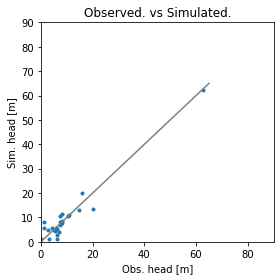

Error is - 2.8421229469818523
Params are - [7.37824818e-01 1.48944083e+01 1.58385460e+01 5.28229307e-01
 1.07274472e+00 4.95667976e-01 2.40293247e-03 6.57425932e-01
 1.58204129e-01 2.97221445e-01 1.79203854e-03 3.77148871e+00]


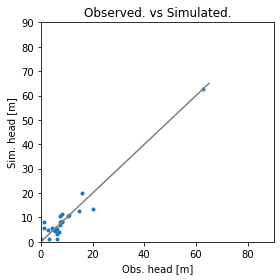

Error is - 2.841491058247839
Params are - [7.32040276e-01 1.48045614e+01 1.59170328e+01 5.20031483e-01
 1.07374800e+00 4.86952776e-01 2.36893688e-03 6.63045738e-01
 1.59831277e-01 2.94708608e-01 1.85549137e-03 3.77801526e+00]


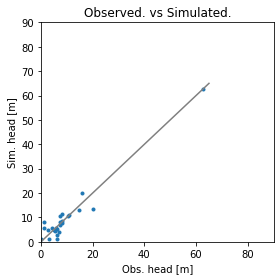

Error is - 2.842437164758197
Params are - [7.40333895e-01 1.49145378e+01 1.58678664e+01 5.29335634e-01
 1.07706935e+00 4.93758943e-01 2.37642036e-03 6.56326980e-01
 1.56043929e-01 2.97198119e-01 1.83575038e-03 3.75542923e+00]


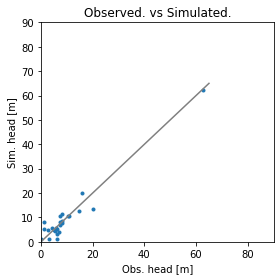

Error is - 2.841345786558858
Params are - [7.28723088e-01 1.50667959e+01 1.57791258e+01 5.23724191e-01
 1.07544821e+00 4.83695142e-01 2.37767061e-03 6.58542913e-01
 1.60936894e-01 2.98460031e-01 1.82581648e-03 3.76129185e+00]


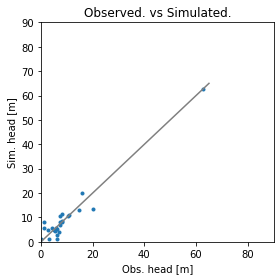

Error is - 2.842589470658168
Params are - [7.23448663e-01 1.52085229e+01 1.58662086e+01 5.28097334e-01
 1.06534870e+00 4.73838642e-01 2.37975910e-03 6.61300226e-01
 1.59005193e-01 2.95606842e-01 1.87883146e-03 3.78012422e+00]


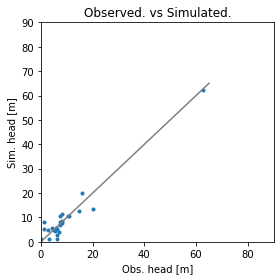

Error is - 2.841355427717977
Params are - [7.35771243e-01 1.49458640e+01 1.57829464e+01 5.24411075e-01
 1.08011064e+00 4.91880396e-01 2.37631432e-03 6.56509997e-01
 1.59598792e-01 2.99040108e-01 1.80924655e-03 3.75138087e+00]


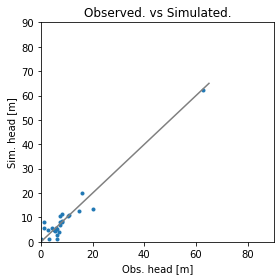

Error is - 2.8410902700540843
Params are - [7.39694684e-01 1.47375535e+01 1.57647524e+01 5.26426674e-01
 1.07924308e+00 4.89934268e-01 2.37847625e-03 6.61435443e-01
 1.59726847e-01 2.94574752e-01 1.83397033e-03 3.76954613e+00]


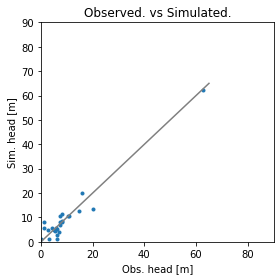

Error is - 2.8410603194616857
Params are - [7.46858616e-01 1.44690769e+01 1.57240688e+01 5.27245085e-01
 1.08265518e+00 4.93281935e-01 2.37949954e-03 6.64640435e-01
 1.60015356e-01 2.91409284e-01 1.83704672e-03 3.77820148e+00]


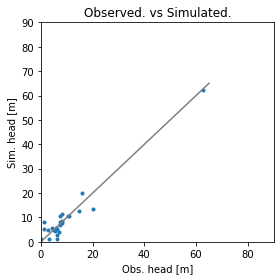

Error is - 2.8415234972976346
Params are - [7.17921812e-01 1.45268674e+01 1.59448014e+01 5.27874219e-01
 1.08130800e+00 4.91900784e-01 2.37491120e-03 6.64550011e-01
 1.59630872e-01 2.99585413e-01 1.81861019e-03 3.78272171e+00]


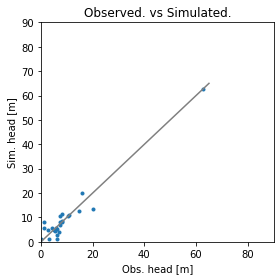

Error is - 2.8411922711400446
Params are - [7.39805106e-01 1.51367418e+01 1.57419674e+01 5.24893440e-01
 1.07441045e+00 4.85216243e-01 2.37867079e-03 6.56434551e-01
 1.59424524e-01 2.96337009e-01 1.83637892e-03 3.75416905e+00]


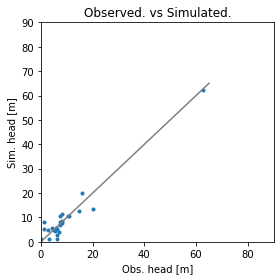

Error is - 2.841453396894496
Params are - [7.34275212e-01 1.51177027e+01 1.56729471e+01 5.32552909e-01
 1.07978168e+00 4.87646647e-01 2.38752062e-03 6.54131806e-01
 1.59087544e-01 3.00402413e-01 1.80223524e-03 3.74538358e+00]


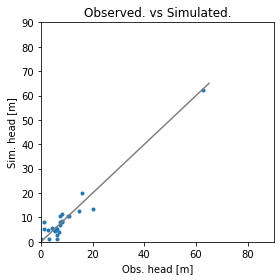

Error is - 2.841296148028735
Params are - [7.39547343e-01 1.48132072e+01 1.57513551e+01 5.35721341e-01
 1.09091749e+00 4.93412989e-01 2.37613296e-03 6.46339955e-01
 1.57647823e-01 2.93077808e-01 1.84175137e-03 3.77896131e+00]


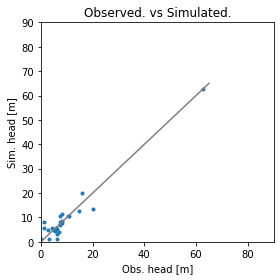

Error is - 2.8413258756708104
Params are - [7.41260473e-01 1.49225620e+01 1.56884712e+01 5.29015774e-01
 1.07356536e+00 4.85841110e-01 2.36625807e-03 6.57959811e-01
 1.61109579e-01 2.99075557e-01 1.80090523e-03 3.77423253e+00]


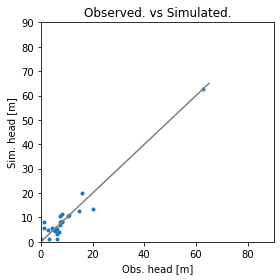

Error is - 2.841552154641065
Params are - [7.36194052e-01 1.47464545e+01 1.58778825e+01 5.23099271e-01
 1.07637907e+00 4.88107853e-01 2.36426478e-03 6.59798450e-01
 1.59877862e-01 2.93865253e-01 1.85143440e-03 3.78719569e+00]


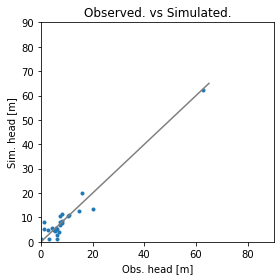

Error is - 2.841254089872471
Params are - [7.34754922e-01 1.50248906e+01 1.57241810e+01 5.30189499e-01
 1.07893103e+00 4.87761949e-01 2.38170666e-03 6.55548467e-01
 1.59285123e-01 2.98768123e-01 1.81453503e-03 3.75583661e+00]


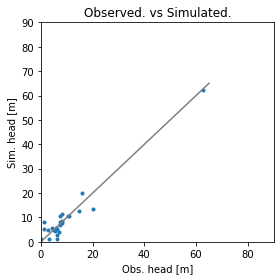

Error is - 2.841360030201315
Params are - [7.36587849e-01 1.48515524e+01 1.58444258e+01 5.28639118e-01
 1.08362769e+00 4.85902549e-01 2.38129887e-03 6.54934101e-01
 1.59932330e-01 2.98169254e-01 1.82275730e-03 3.74282089e+00]


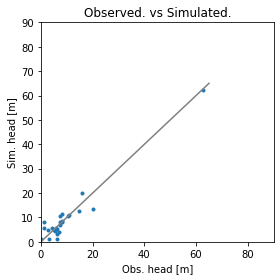

Error is - 2.8411569309130797
Params are - [7.33492624e-01 1.49293862e+01 1.58254944e+01 5.28072580e-01
 1.07508794e+00 4.91704917e-01 2.38492279e-03 6.57376185e-01
 1.60596777e-01 2.94985268e-01 1.81614370e-03 3.75031625e+00]


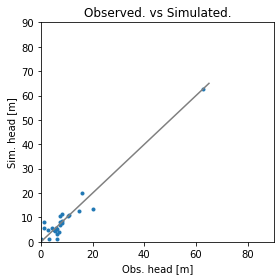

Error is - 2.841058773094225
Params are - [7.32507924e-01 1.48719095e+01 1.57012140e+01 5.24069413e-01
 1.07354499e+00 4.99210043e-01 2.37418144e-03 6.58843962e-01
 1.60781103e-01 2.97135343e-01 1.82280882e-03 3.76880988e+00]


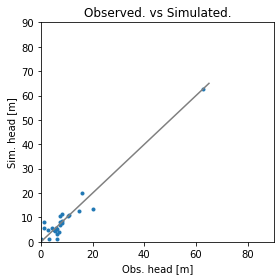

Error is - 2.841090015969141
Params are - [7.30078374e-01 1.48206809e+01 1.56205120e+01 5.20331901e-01
 1.06905514e+00 5.09456177e-01 2.37047475e-03 6.60839341e-01
 1.61798220e-01 2.97218264e-01 1.82159770e-03 3.77648604e+00]


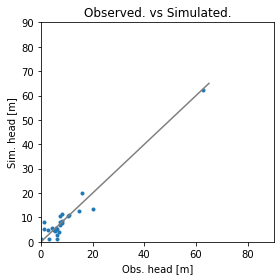

Error is - 2.8410735642754474
Params are - [7.38268665e-01 1.47909920e+01 1.57477915e+01 5.26065422e-01
 1.07832061e+00 4.96530001e-01 2.38739866e-03 6.56860691e-01
 1.59429802e-01 2.96935456e-01 1.81437076e-03 3.74898231e+00]


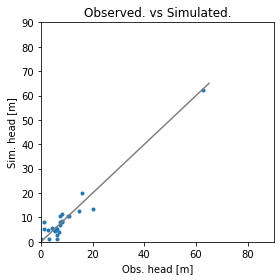

Error is - 2.8414333648777554
Params are - [7.57805998e-01 1.48928473e+01 1.56098803e+01 5.29030550e-01
 1.08692540e+00 4.86841071e-01 2.38642865e-03 6.54002107e-01
 1.60065817e-01 2.93393936e-01 1.79893934e-03 3.77144196e+00]


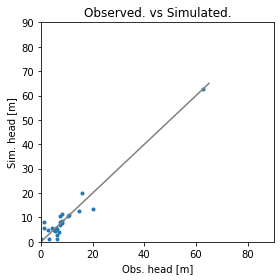

Error is - 2.8411912640051344
Params are - [7.26393129e-01 1.49040391e+01 1.58353001e+01 5.26636450e-01
 1.07418666e+00 4.92244349e-01 2.37608492e-03 6.58152498e-01
 1.59672323e-01 2.98474026e-01 1.83184182e-03 3.75537112e+00]


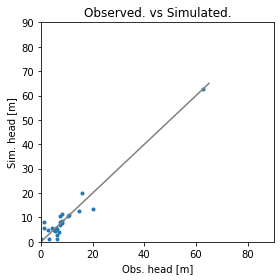

Error is - 2.8413123764871386
Params are - [7.35441201e-01 1.49578124e+01 1.56743735e+01 5.25896071e-01
 1.07166461e+00 4.96040931e-01 2.37689781e-03 6.59140368e-01
 1.59631310e-01 2.95442865e-01 1.82050544e-03 3.78072696e+00]


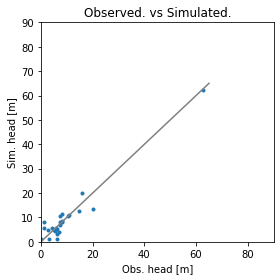

Error is - 2.8409871725387683
Params are - [7.36202800e-01 1.48654923e+01 1.57177574e+01 5.30371613e-01
 1.07377399e+00 4.90756505e-01 2.38197961e-03 6.58002867e-01
 1.59970268e-01 2.93972471e-01 1.83589268e-03 3.77705800e+00]


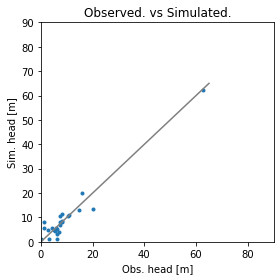

Error is - 2.8414278784222806
Params are - [7.36418578e-01 1.48253065e+01 1.56851630e+01 5.33351882e-01
 1.07060566e+00 4.90194560e-01 2.38481226e-03 6.58749302e-01
 1.60156007e-01 2.91438653e-01 1.84921574e-03 3.78989656e+00]


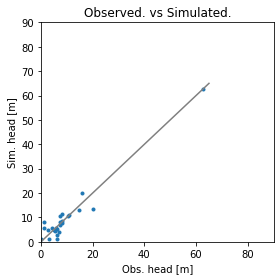

Error is - 2.841041131187668
Params are - [7.44497574e-01 1.47110098e+01 1.57113499e+01 5.32166400e-01
 1.07815739e+00 5.00118653e-01 2.38134148e-03 6.55879943e-01
 1.58471062e-01 2.93804621e-01 1.82100211e-03 3.76977470e+00]


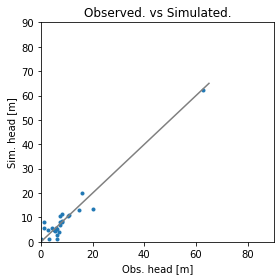

Error is - 2.841566217710419
Params are - [7.32499705e-01 1.48199849e+01 1.58058177e+01 5.27399922e-01
 1.08080558e+00 5.00352276e-01 2.39526793e-03 6.56116400e-01
 1.57858624e-01 2.92310606e-01 1.84926284e-03 3.75609106e+00]


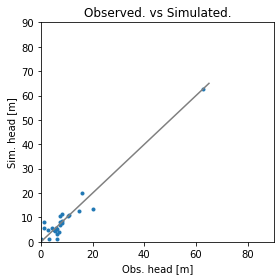

Error is - 2.841119218168952
Params are - [7.39070281e-01 1.48969178e+01 1.57178078e+01 5.28611811e-01
 1.07537541e+00 4.89468901e-01 2.37351053e-03 6.57498958e-01
 1.60296840e-01 2.97384320e-01 1.81299463e-03 3.76969716e+00]


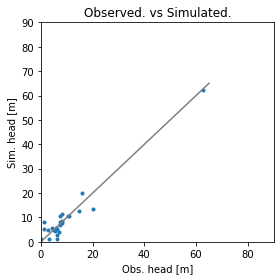

Error is - 2.8411910403337024
Params are - [7.38923824e-01 1.47745854e+01 1.58271545e+01 5.30972248e-01
 1.08332479e+00 4.89057118e-01 2.38406364e-03 6.54662275e-01
 1.59447815e-01 2.96266874e-01 1.82841083e-03 3.74775832e+00]


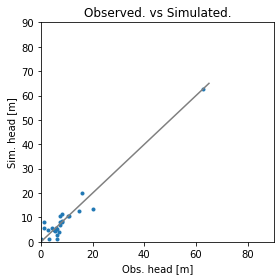

Error is - 2.841012266546091
Params are - [7.40262635e-01 1.47173177e+01 1.56933603e+01 5.30335689e-01
 1.08187237e+00 4.93912132e-01 2.36957621e-03 6.56136118e-01
 1.60289390e-01 2.93450394e-01 1.84346519e-03 3.76208888e+00]


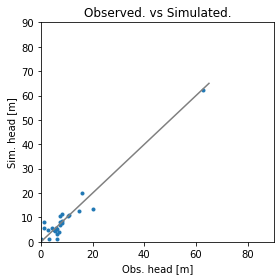

Error is - 2.841185833492068
Params are - [7.35625673e-01 1.48688527e+01 1.57432194e+01 5.20883600e-01
 1.06402265e+00 4.91464135e-01 2.38268975e-03 6.68666204e-01
 1.61965574e-01 2.98409391e-01 1.81073049e-03 3.74404932e+00]


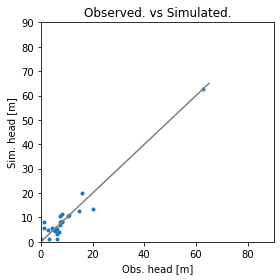

Error is - 2.8408993304163097
Params are - [7.40563220e-01 1.46311629e+01 1.57735666e+01 5.24864459e-01
 1.07352438e+00 4.97732206e-01 2.37727990e-03 6.61643981e-01
 1.60775016e-01 2.92659286e-01 1.83731275e-03 3.76520947e+00]


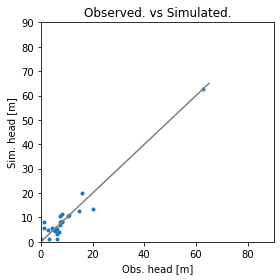

Error is - 2.841206584343515
Params are - [7.43467369e-01 1.44342991e+01 1.57982594e+01 5.22201939e-01
 1.07082106e+00 5.02717335e-01 2.37506652e-03 6.64691738e-01
 1.61519962e-01 2.89604868e-01 1.84870161e-03 3.76989590e+00]


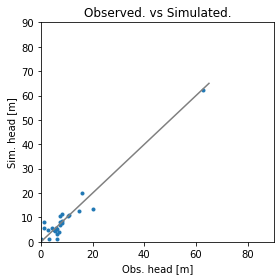

Error is - 2.8409376157129116
Params are - [7.35639388e-01 1.44350486e+01 1.57610467e+01 5.30155688e-01
 1.07789727e+00 5.02363907e-01 2.38008396e-03 6.61626135e-01
 1.60860697e-01 2.94477446e-01 1.81562450e-03 3.76871710e+00]


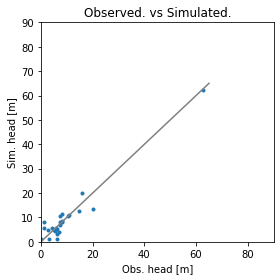

Error is - 2.8408872809816286
Params are - [7.50592409e-01 1.45895862e+01 1.56553385e+01 5.28999218e-01
 1.07873950e+00 4.97022394e-01 2.38333633e-03 6.60487127e-01
 1.60810960e-01 2.91674334e-01 1.81745871e-03 3.76973935e+00]


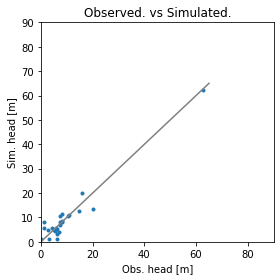

Error is - 2.8410031761141576
Params are - [7.62692049e-01 1.44323597e+01 1.55653578e+01 5.30180603e-01
 1.08101592e+00 4.99411416e-01 2.38696203e-03 6.61654442e-01
 1.61380279e-01 2.88274487e-01 1.81026715e-03 3.77692347e+00]


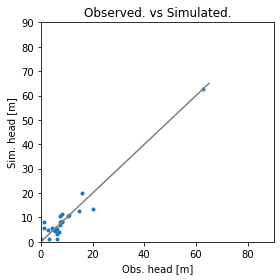

Error is - 2.841140384768602
Params are - [7.40006477e-01 1.46882067e+01 1.56348481e+01 5.24334581e-01
 1.06883716e+00 5.01537171e-01 2.37523640e-03 6.64948159e-01
 1.61262660e-01 2.93116062e-01 1.81906435e-03 3.78101566e+00]


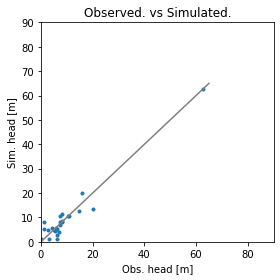

Error is - 2.841010046336377
Params are - [7.44034762e-01 1.45638317e+01 1.57007213e+01 5.34998393e-01
 1.08894172e+00 5.00808993e-01 2.37536806e-03 6.50324557e-01
 1.58627747e-01 2.90091324e-01 1.83813366e-03 3.79088572e+00]


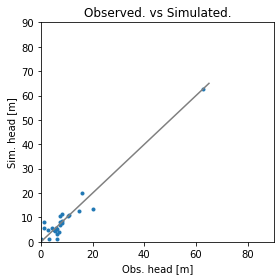

Error is - 2.8408447064980678
Params are - [7.47924834e-01 1.44423725e+01 1.55976508e+01 5.28963716e-01
 1.08018539e+00 5.02085556e-01 2.37154256e-03 6.60439304e-01
 1.59668373e-01 2.92699789e-01 1.83638545e-03 3.79138037e+00]


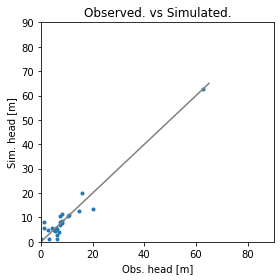

Error is - 2.8410056473299585
Params are - [7.55140939e-01 1.41988657e+01 1.54837290e+01 5.29409284e-01
 1.08273412e+00 5.07275875e-01 2.36485244e-03 6.61970863e-01
 1.59204170e-01 2.91557050e-01 1.84650633e-03 3.81191243e+00]


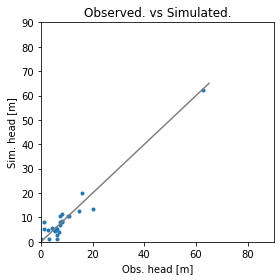

Error is - 2.8411285404928543
Params are - [7.42730707e-01 1.46425796e+01 1.57820975e+01 5.33473237e-01
 1.08832755e+00 4.92344700e-01 2.38061332e-03 6.52115854e-01
 1.58736776e-01 2.94499616e-01 1.83635165e-03 3.76240841e+00]


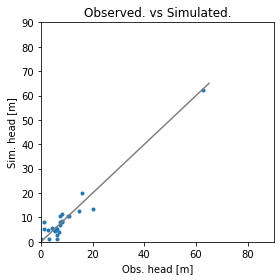

Error is - 2.8409738405560403
Params are - [7.42049650e-01 1.46539864e+01 1.57452852e+01 5.31188573e-01
 1.08345495e+00 4.94642818e-01 2.37926909e-03 6.55323930e-01
 1.59368247e-01 2.94153728e-01 1.83202982e-03 3.76706022e+00]


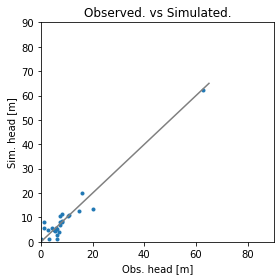

Error is - 2.840818554187299
Params are - [7.44163465e-01 1.43933800e+01 1.57037174e+01 5.29625467e-01
 1.08313588e+00 5.05275289e-01 2.38329894e-03 6.59202550e-01
 1.59547830e-01 2.89692927e-01 1.84559390e-03 3.77328742e+00]


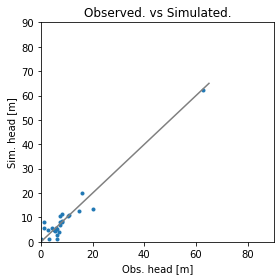

Error is - 2.8409307061560605
Params are - [7.46710056e-01 1.41416111e+01 1.56966722e+01 5.30132296e-01
 1.08701611e+00 5.13178483e-01 2.38819314e-03 6.60054346e-01
 1.59173324e-01 2.85847230e-01 1.86189353e-03 3.77508255e+00]


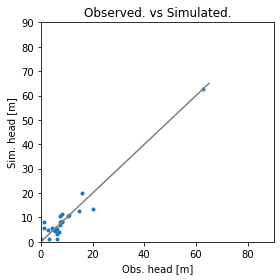

Error is - 2.841007568411089
Params are - [7.45947548e-01 1.44330370e+01 1.56663879e+01 5.32765197e-01
 1.08099323e+00 4.99671738e-01 2.36872753e-03 6.60231127e-01
 1.60434539e-01 2.88934702e-01 1.84942162e-03 3.79805312e+00]


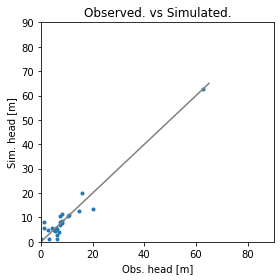

Error is - 2.8407558749863564
Params are - [7.37205752e-01 1.47489455e+01 1.56804972e+01 5.32505553e-01
 1.07638167e+00 5.03984770e-01 2.37483131e-03 6.51716499e-01
 1.59918850e-01 2.94048444e-01 1.82880814e-03 3.77214256e+00]


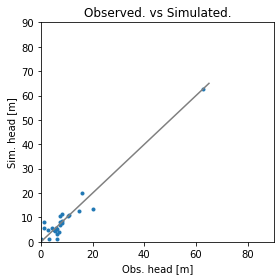

Error is - 2.840759053431562
Params are - [7.32379321e-01 1.48888798e+01 1.56587114e+01 5.35135787e-01
 1.07324492e+00 5.09336187e-01 2.37249720e-03 6.45254530e-01
 1.59870597e-01 2.95368024e-01 1.82468885e-03 3.76911310e+00]


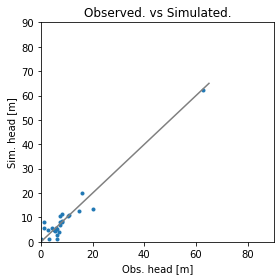

Error is - 2.840893348748194
Params are - [7.52339415e-01 1.43256189e+01 1.56998992e+01 5.37087248e-01
 1.08596463e+00 4.98852451e-01 2.38025772e-03 6.56325062e-01
 1.59009393e-01 2.87807901e-01 1.84404593e-03 3.78208961e+00]


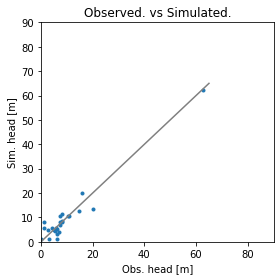

Error is - 2.8409264493377377
Params are - [7.41656739e-01 1.44222868e+01 1.56878548e+01 5.29810402e-01
 1.08265344e+00 4.97732806e-01 2.37291706e-03 6.59363266e-01
 1.61409157e-01 2.90139170e-01 1.84969328e-03 3.78317727e+00]


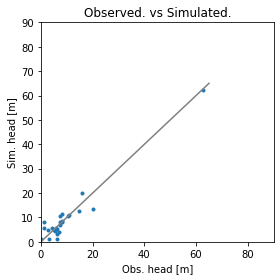

Error is - 2.840804845853358
Params are - [7.46124029e-01 1.43668071e+01 1.57049269e+01 5.31553566e-01
 1.07906863e+00 5.04576107e-01 2.38523913e-03 6.59644949e-01
 1.59777456e-01 2.89941526e-01 1.82826822e-03 3.79437782e+00]


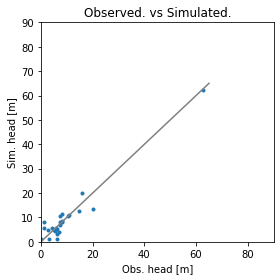

Error is - 2.8408188760585467
Params are - [7.42700112e-01 1.44874556e+01 1.56982668e+01 5.26316724e-01
 1.07035377e+00 4.98307099e-01 2.38109246e-03 6.67009910e-01
 1.61630717e-01 2.93275630e-01 1.83195551e-03 3.76616300e+00]


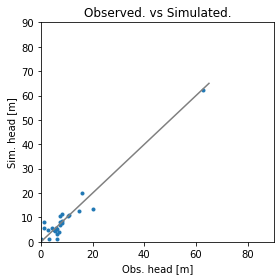

Error is - 2.8409113266196595
Params are - [7.40246088e-01 1.46273201e+01 1.57379133e+01 5.27475174e-01
 1.07652903e+00 4.99216914e-01 2.38979381e-03 6.58233136e-01
 1.60023288e-01 2.95155740e-01 1.81775652e-03 3.75368057e+00]


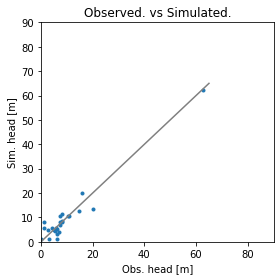

Error is - 2.8408472669829856
Params are - [7.50664717e-01 1.41551695e+01 1.56899031e+01 5.29386018e-01
 1.08420744e+00 5.09542214e-01 2.37784410e-03 6.60499774e-01
 1.60496395e-01 2.90315182e-01 1.82826278e-03 3.77077946e+00]


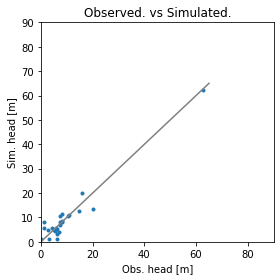

Error is - 2.84073103917043
Params are - [7.46253712e-01 1.42835392e+01 1.56531451e+01 5.28268633e-01
 1.07465189e+00 5.08139134e-01 2.38031713e-03 6.64041352e-01
 1.61286442e-01 2.89494168e-01 1.83149779e-03 3.78139711e+00]


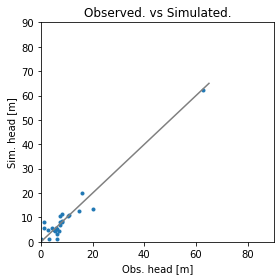

Error is - 2.841193578224855
Params are - [7.48355742e-01 1.40983156e+01 1.56070750e+01 5.26808663e-01
 1.07025036e+00 5.14887292e-01 2.38084115e-03 6.68400063e-01
 1.62245539e-01 2.87164389e-01 1.83123178e-03 3.78856555e+00]


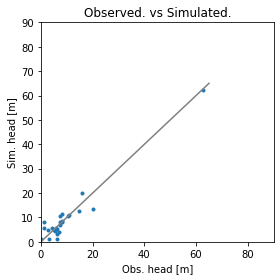

Error is - 2.840715700207399
Params are - [7.54433027e-01 1.44772255e+01 1.56193999e+01 5.28987008e-01
 1.07966867e+00 5.01380583e-01 2.37954112e-03 6.58141683e-01
 1.59864949e-01 2.88339903e-01 1.85054867e-03 3.78185357e+00]


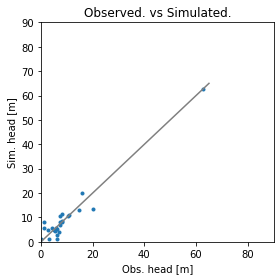

Error is - 2.8411081511770084
Params are - [7.63829847e-01 1.44983140e+01 1.55485765e+01 5.28402668e-01
 1.08055437e+00 5.00888921e-01 2.37926969e-03 6.56399457e-01
 1.59367075e-01 2.85271131e-01 1.86801075e-03 3.78842181e+00]


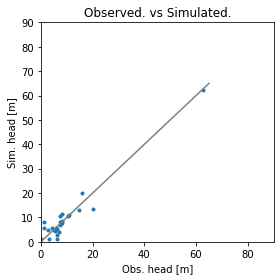

Error is - 2.8412322181264655
Params are - [7.50545058e-01 1.44991437e+01 1.56811827e+01 5.29195062e-01
 1.07441504e+00 5.06619647e-01 2.38781203e-03 6.60200955e-01
 1.59059121e-01 2.92378302e-01 1.81662245e-03 3.76717279e+00]


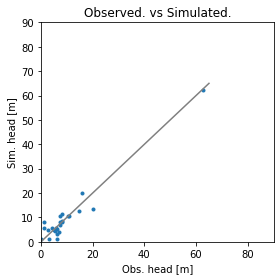

Error is - 2.840822645787245
Params are - [7.43878819e-01 1.44415010e+01 1.56861868e+01 5.29656567e-01
 1.08059384e+00 4.99954516e-01 2.37664080e-03 6.59572688e-01
 1.60821648e-01 2.90698953e-01 1.84142557e-03 3.77917615e+00]


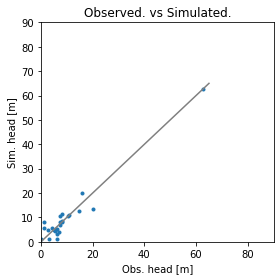

Error is - 2.840984324824263
Params are - [7.52561164e-01 1.42631406e+01 1.56225031e+01 5.31893855e-01
 1.08121692e+00 5.05258473e-01 2.36874310e-03 6.61554344e-01
 1.60578050e-01 2.86618934e-01 1.85250405e-03 3.80091874e+00]


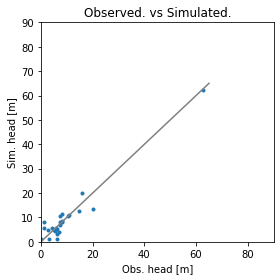

Error is - 2.8407808020790757
Params are - [7.43324857e-01 1.45362752e+01 1.57090608e+01 5.28579845e-01
 1.07770100e+00 5.00727303e-01 2.38453114e-03 6.59063438e-01
 1.60161978e-01 2.93021539e-01 1.82644341e-03 3.76549012e+00]


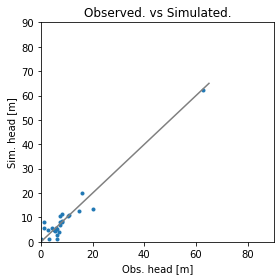

Error is - 2.84070986880223
Params are - [7.52704305e-01 1.42434831e+01 1.55760988e+01 5.35123802e-01
 1.08491767e+00 5.07242363e-01 2.38246555e-03 6.57713408e-01
 1.59724150e-01 2.89175763e-01 1.83113626e-03 3.78943662e+00]


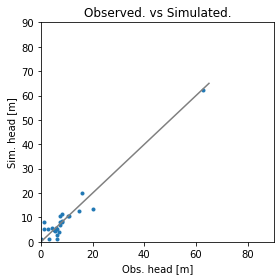

Error is - 2.840812315044295
Params are - [7.58774847e-01 1.40496432e+01 1.54773649e+01 5.40253473e-01
 1.09061432e+00 5.11997441e-01 2.38505838e-03 6.55748122e-01
 1.59198717e-01 2.87434001e-01 1.82804802e-03 3.80155019e+00]


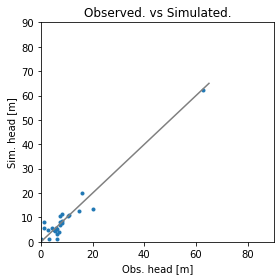

Error is - 2.8407746858718124
Params are - [7.40988924e-01 1.45353379e+01 1.56291328e+01 5.22573771e-01
 1.07230293e+00 5.07520437e-01 2.37985571e-03 6.63263719e-01
 1.61608898e-01 2.94255125e-01 1.82225147e-03 3.77378099e+00]


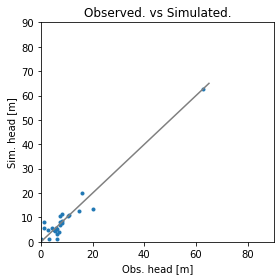

Error is - 2.8406604994067846
Params are - [7.41135350e-01 1.42623292e+01 1.56693259e+01 5.29590893e-01
 1.07845530e+00 5.11100168e-01 2.37619700e-03 6.59564418e-01
 1.59940321e-01 2.90818825e-01 1.84963749e-03 3.78680484e+00]


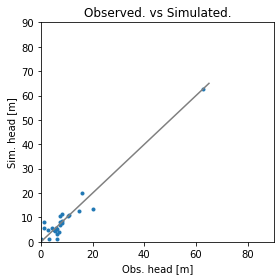

Error is - 2.840831236936312
Params are - [7.36406821e-01 1.40987007e+01 1.56763196e+01 5.29886731e-01
 1.07831319e+00 5.18139056e-01 2.37262733e-03 6.59103063e-01
 1.59505001e-01 2.90391070e-01 1.86572688e-03 3.79533759e+00]


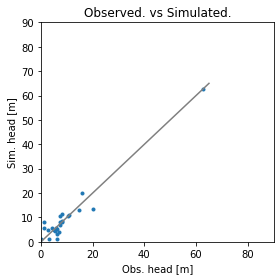

Error is - 2.8410581080959934
Params are - [7.39474814e-01 1.47146059e+01 1.56313317e+01 5.29238239e-01
 1.07202867e+00 4.98840007e-01 2.38141471e-03 6.59395878e-01
 1.60162206e-01 2.92261916e-01 1.84239587e-03 3.78843563e+00]


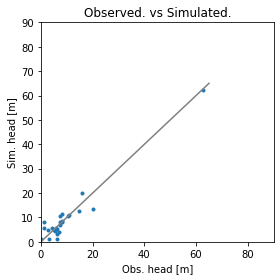

Error is - 2.8407563393146855
Params are - [7.47867241e-01 1.42950286e+01 1.56752603e+01 5.29349074e-01
 1.08116275e+00 5.06866662e-01 2.37873675e-03 6.60223800e-01
 1.60412848e-01 2.90801866e-01 1.83179605e-03 3.77519351e+00]


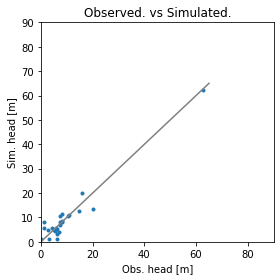

Error is - 2.8407906567136734
Params are - [7.42205098e-01 1.44028455e+01 1.57365190e+01 5.29724768e-01
 1.07621361e+00 5.07093516e-01 2.38891528e-03 6.59420432e-01
 1.61114308e-01 2.89560989e-01 1.83350829e-03 3.76513691e+00]


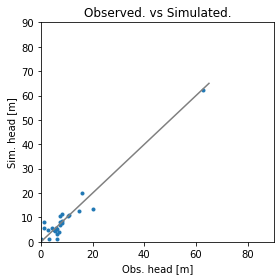

Error is - 2.8408476154454685
Params are - [7.45972160e-01 1.43972744e+01 1.56563717e+01 5.29043284e-01
 1.07507512e+00 5.10414389e-01 2.38586279e-03 6.60261671e-01
 1.60009810e-01 2.91372164e-01 1.82714863e-03 3.77500126e+00]


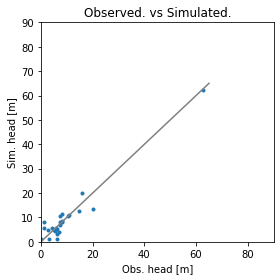

Error is - 2.8407520103243615
Params are - [7.44402154e-01 1.44304444e+01 1.56787330e+01 5.29503246e-01
 1.07921416e+00 5.02569484e-01 2.37894630e-03 6.59744934e-01
 1.60618688e-01 2.90867256e-01 1.83785634e-03 3.77813243e+00]


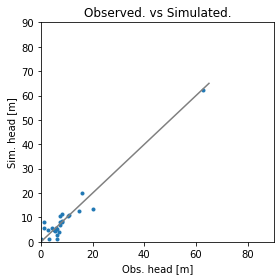

Error is - 2.8407094804051343
Params are - [7.47434540e-01 1.43418179e+01 1.56410360e+01 5.32914214e-01
 1.08679192e+00 5.12772204e-01 2.38105343e-03 6.51613621e-01
 1.59032069e-01 2.88394091e-01 1.83760216e-03 3.79000932e+00]


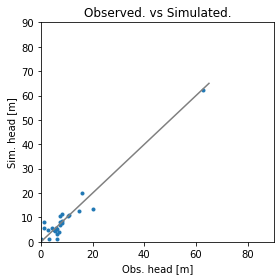

Error is - 2.8406036647430226
Params are - [7.46516367e-01 1.44272998e+01 1.56251386e+01 5.30153595e-01
 1.07461915e+00 5.07053500e-01 2.37847270e-03 6.58156159e-01
 1.61028997e-01 2.91760322e-01 1.82263182e-03 3.78567188e+00]


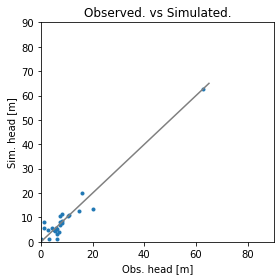

Error is - 2.8405998235039815
Params are - [7.47692818e-01 1.44442598e+01 1.55858492e+01 5.30417659e-01
 1.07036079e+00 5.07942605e-01 2.37605958e-03 6.57632963e-01
 1.61769580e-01 2.92794020e-01 1.81115078e-03 3.79186411e+00]


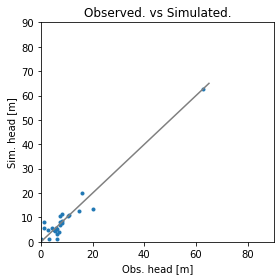

Error is - 2.8406096604928646
Params are - [7.44817268e-01 1.44667815e+01 1.56040827e+01 5.28036178e-01
 1.07723509e+00 5.08313765e-01 2.37500258e-03 6.57378429e-01
 1.61131391e-01 2.91987138e-01 1.83710459e-03 3.76416252e+00]


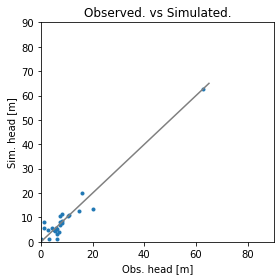

Error is - 2.8407962254012498
Params are - [7.49171560e-01 1.44413991e+01 1.55504179e+01 5.29583545e-01
 1.08026037e+00 5.05999731e-01 2.36900765e-03 6.57262612e-01
 1.59797386e-01 2.92772034e-01 1.83246390e-03 3.79324103e+00]


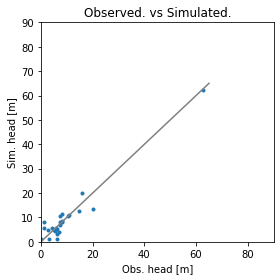

Error is - 2.840683535576295
Params are - [7.43946713e-01 1.44124839e+01 1.56899937e+01 5.29689462e-01
 1.07722530e+00 5.06820070e-01 2.38393837e-03 6.58880977e-01
 1.60785078e-01 2.90363750e-01 1.83324720e-03 3.77216294e+00]


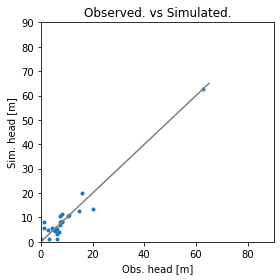

Error is - 2.840608967817319
Params are - [7.48155444e-01 1.42873375e+01 1.55746984e+01 5.30913404e-01
 1.07869369e+00 5.13381404e-01 2.37329300e-03 6.57589196e-01
 1.60853565e-01 2.88868520e-01 1.84066275e-03 3.79399997e+00]


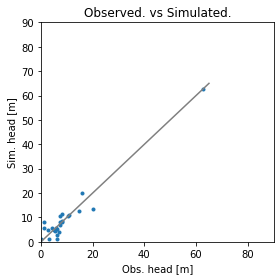

Error is - 2.8406942154689903
Params are - [7.51685796e-01 1.42469415e+01 1.56455539e+01 5.38309417e-01
 1.08515689e+00 5.07565099e-01 2.37687464e-03 6.52443161e-01
 1.59280757e-01 2.86737166e-01 1.84792324e-03 3.78907893e+00]


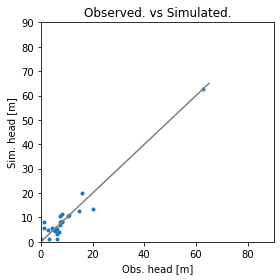

Error is - 2.8405605824809523
Params are - [7.45443905e-01 1.44792363e+01 1.55944753e+01 5.33027505e-01
 1.07696276e+00 5.08335279e-01 2.37768325e-03 6.54186306e-01
 1.60288125e-01 2.89512975e-01 1.84106651e-03 3.78998065e+00]


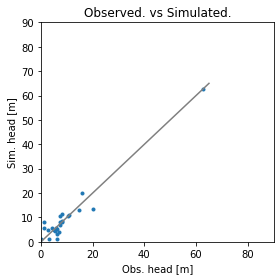

Error is - 2.840788287639097
Params are - [7.44232237e-01 1.45713401e+01 1.55540829e+01 5.34866720e-01
 1.07486277e+00 5.09069588e-01 2.37715650e-03 6.51167559e-01
 1.60225764e-01 2.88868529e-01 1.84570175e-03 3.79737422e+00]


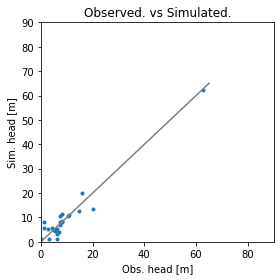

Error is - 2.8407982232353928
Params are - [7.57478420e-01 1.39803678e+01 1.55749014e+01 5.29958017e-01
 1.08184068e+00 5.11942257e-01 2.38206401e-03 6.63105243e-01
 1.60843670e-01 2.85510485e-01 1.84609748e-03 3.79600461e+00]


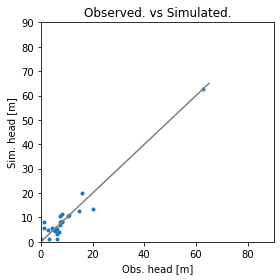

Error is - 2.840643472265273
Params are - [7.42273919e-01 1.45568011e+01 1.56540983e+01 5.31868669e-01
 1.07774642e+00 5.05974142e-01 2.37663949e-03 6.54563685e-01
 1.60150055e-01 2.91913954e-01 1.83313048e-03 3.77810807e+00]


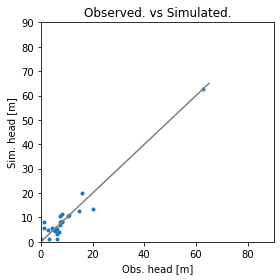

Error is - 2.840472991330726
Params are - [7.49927312e-01 1.43199284e+01 1.55725598e+01 5.33354561e-01
 1.07876357e+00 5.13924985e-01 2.37756456e-03 6.54213266e-01
 1.60065725e-01 2.88866123e-01 1.83626165e-03 3.79001068e+00]


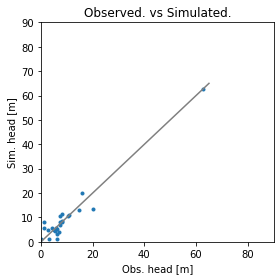

Error is - 2.840580635345317
Params are - [7.52689891e-01 1.42646704e+01 1.55194733e+01 5.35280219e-01
 1.07853828e+00 5.19602735e-01 2.37687369e-03 6.51447431e-01
 1.59789244e-01 2.87865557e-01 1.83546431e-03 3.79594981e+00]


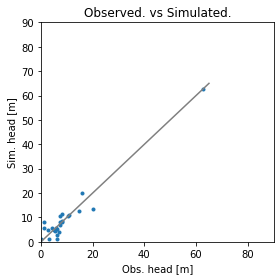

Error is - 2.8405344781605333
Params are - [7.48688021e-01 1.44728984e+01 1.55847169e+01 5.35436829e-01
 1.08401112e+00 5.09319644e-01 2.37573497e-03 6.48278833e-01
 1.59194519e-01 2.90134536e-01 1.84341417e-03 3.78818160e+00]


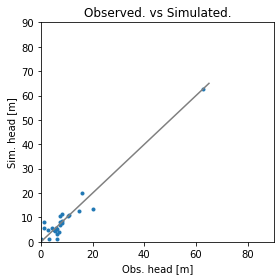

Error is - 2.840533200932175
Params are - [7.39551205e-01 1.42784909e+01 1.56126816e+01 5.35793424e-01
 1.07971808e+00 5.17401372e-01 2.37587662e-03 6.52534694e-01
 1.60504273e-01 2.91587907e-01 1.82317421e-03 3.78877980e+00]


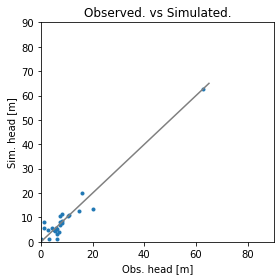

Error is - 2.8406442031202994
Params are - [7.39087744e-01 1.45180679e+01 1.56620798e+01 5.29768234e-01
 1.07360248e+00 5.13232760e-01 2.37185403e-03 6.52099850e-01
 1.60775093e-01 2.91154071e-01 1.84125961e-03 3.78108729e+00]


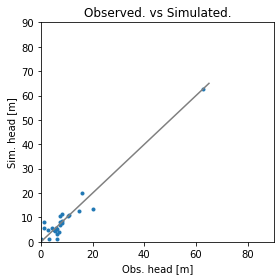

Error is - 2.8406537092198274
Params are - [7.42966376e-01 1.44491082e+01 1.56006499e+01 5.31453492e-01
 1.06953000e+00 5.07779678e-01 2.37173292e-03 6.58280676e-01
 1.61757678e-01 2.92395740e-01 1.83540328e-03 3.77902758e+00]


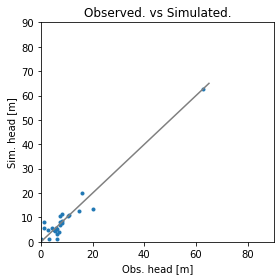

Error is - 2.8406845535282854
Params are - [7.37261883e-01 1.45776790e+01 1.55886481e+01 5.24915635e-01
 1.06856055e+00 5.13022547e-01 2.37505475e-03 6.58424054e-01
 1.61921810e-01 2.94995761e-01 1.82299555e-03 3.77828275e+00]


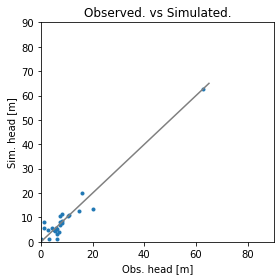

Error is - 2.8405831953694984
Params are - [7.40867861e-01 1.44949946e+01 1.56028745e+01 5.28264081e-01
 1.07270963e+00 5.11658185e-01 2.37550973e-03 6.56928831e-01
 1.61261547e-01 2.92931112e-01 1.82922747e-03 3.78098179e+00]


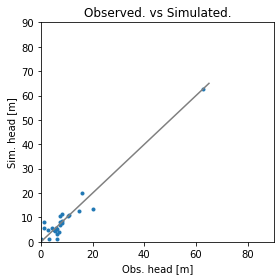

Error is - 2.840654199352847
Params are - [7.44487824e-01 1.44258884e+01 1.55296883e+01 5.33298026e-01
 1.07573952e+00 5.14573928e-01 2.36658625e-03 6.51660881e-01
 1.60496901e-01 2.91797070e-01 1.83700164e-03 3.79666854e+00]


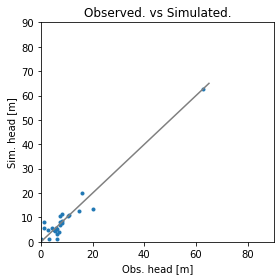

Error is - 2.8404806082395093
Params are - [7.47857933e-01 1.46033029e+01 1.55270832e+01 5.34014450e-01
 1.07405690e+00 5.10872789e-01 2.37272583e-03 6.49660183e-01
 1.61434422e-01 2.91505036e-01 1.81850537e-03 3.78367059e+00]


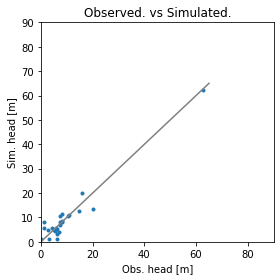

Error is - 2.8406474217436557
Params are - [7.45067144e-01 1.44693128e+01 1.56662866e+01 5.30426722e-01
 1.07649223e+00 5.06782173e-01 2.38335985e-03 6.57230271e-01
 1.61034095e-01 2.90478119e-01 1.82805851e-03 3.77164057e+00]


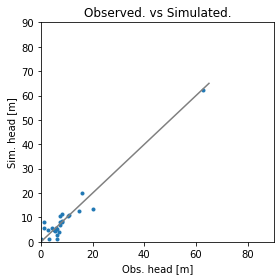

Error is - 2.840599130835386
Params are - [7.46938720e-01 1.44494605e+01 1.56062645e+01 5.32100127e-01
 1.08386213e+00 5.13410173e-01 2.38015099e-03 6.50435409e-01
 1.59652721e-01 2.89559846e-01 1.82843273e-03 3.78805036e+00]


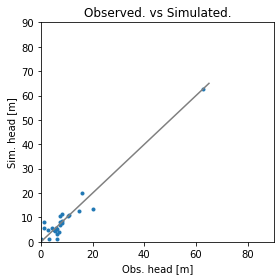

Error is - 2.8406028974223094
Params are - [7.45149881e-01 1.44259471e+01 1.55306241e+01 5.33405799e-01
 1.07812821e+00 5.15512344e-01 2.36798926e-03 6.50353336e-01
 1.60146075e-01 2.91324421e-01 1.83583988e-03 3.79817234e+00]


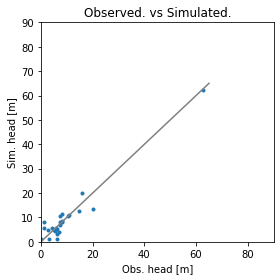

Error is - 2.8405377535498513
Params are - [7.52139637e-01 1.43618386e+01 1.55129216e+01 5.34670547e-01
 1.08177225e+00 5.09441688e-01 2.37885095e-03 6.55192672e-01
 1.60300240e-01 2.90676860e-01 1.82173549e-03 3.79157312e+00]


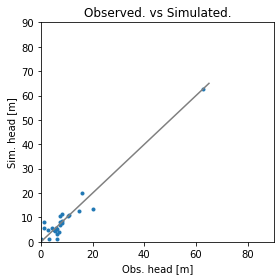

Error is - 2.840409251125128
Params are - [7.50597748e-01 1.42906117e+01 1.54973737e+01 5.33037092e-01
 1.07829928e+00 5.17278231e-01 2.37443407e-03 6.52833669e-01
 1.60950309e-01 2.89710795e-01 1.82796546e-03 3.79679652e+00]


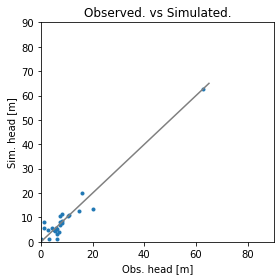

Error is - 2.8403408064785007
Params are - [7.54759663e-01 1.41575170e+01 1.54190114e+01 5.33621303e-01
 1.07857571e+00 5.22930275e-01 2.37333136e-03 6.51968660e-01
 1.61350436e-01 2.88609215e-01 1.82538294e-03 3.80614074e+00]


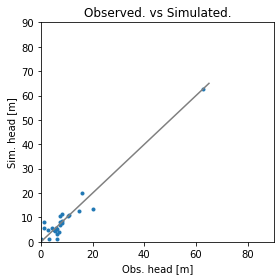

Error is - 2.840389696664209
Params are - [7.49711466e-01 1.43290872e+01 1.55165440e+01 5.37800436e-01
 1.07903405e+00 5.17374692e-01 2.37579244e-03 6.49117296e-01
 1.60005481e-01 2.89074624e-01 1.82203774e-03 3.81773844e+00]


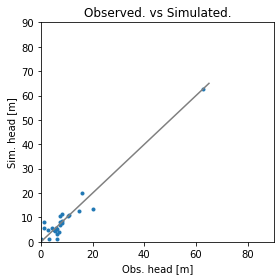

Error is - 2.840371301424134
Params are - [7.46632626e-01 1.45154894e+01 1.55362360e+01 5.36071049e-01
 1.07763218e+00 5.12972601e-01 2.37791859e-03 6.47494546e-01
 1.60141958e-01 2.92227593e-01 1.81537541e-03 3.79185740e+00]


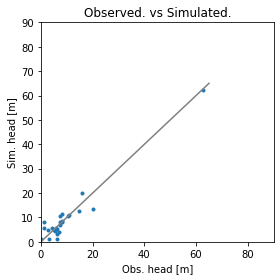

Error is - 2.840538867432839
Params are - [7.49885313e-01 1.43918035e+01 1.55812456e+01 5.34022863e-01
 1.07811498e+00 5.10418371e-01 2.38487722e-03 6.54253941e-01
 1.60848763e-01 2.89922220e-01 1.81678753e-03 3.78663254e+00]


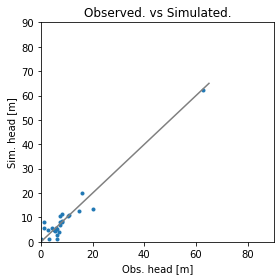

Error is - 2.8404643741694415
Params are - [7.47707792e-01 1.43647482e+01 1.55252533e+01 5.37611871e-01
 1.08717477e+00 5.18400737e-01 2.37827650e-03 6.46411143e-01
 1.59071788e-01 2.87973988e-01 1.84241609e-03 3.79206885e+00]


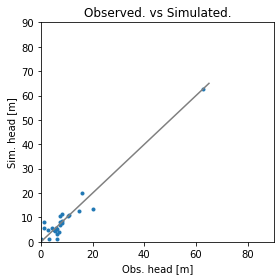

Error is - 2.840370584032413
Params are - [7.48590070e-01 1.43454287e+01 1.54913361e+01 5.36848026e-01
 1.07422554e+00 5.13764930e-01 2.37387267e-03 6.52937987e-01
 1.61091826e-01 2.90943853e-01 1.82746470e-03 3.79655234e+00]


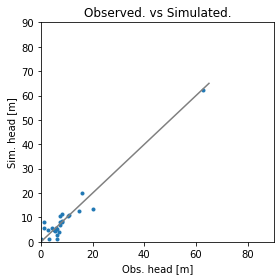

Error is - 2.8403796667044876
Params are - [7.55947963e-01 1.42749669e+01 1.54761363e+01 5.42114730e-01
 1.08563069e+00 5.15868042e-01 2.37824110e-03 6.45779424e-01
 1.59454713e-01 2.87241376e-01 1.82637617e-03 3.80621600e+00]


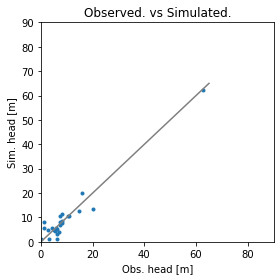

Error is - 2.8403326612773623
Params are - [7.53122595e-01 1.42566804e+01 1.54648123e+01 5.38865844e-01
 1.08282221e+00 5.20446408e-01 2.37616055e-03 6.47120801e-01
 1.60289232e-01 2.90280914e-01 1.81208873e-03 3.79992303e+00]


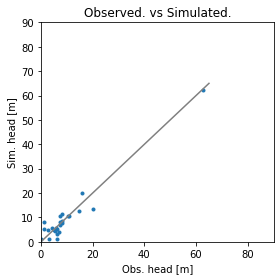

Error is - 2.840312359254502
Params are - [7.56961940e-01 1.41454025e+01 1.53999808e+01 5.41785013e-01
 1.08575194e+00 5.26501973e-01 2.37539920e-03 6.43588049e-01
 1.60289786e-01 2.90664883e-01 1.79759984e-03 3.80489423e+00]


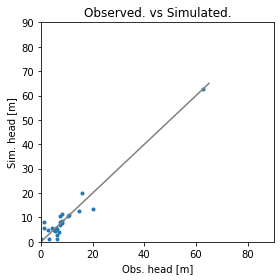

Error is - 2.840462955057326
Params are - [7.49860624e-01 1.43030463e+01 1.54478312e+01 5.39164177e-01
 1.08294282e+00 5.21043917e-01 2.36738691e-03 6.45275519e-01
 1.59635431e-01 2.89995446e-01 1.83316976e-03 3.80631476e+00]


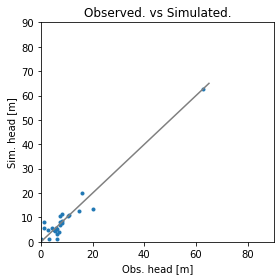

Error is - 2.840291693567739
Params are - [7.47226465e-01 1.43232125e+01 1.55053069e+01 5.39265431e-01
 1.07948064e+00 5.23954305e-01 2.37150251e-03 6.42683928e-01
 1.60073153e-01 2.89127237e-01 1.83012752e-03 3.80383111e+00]


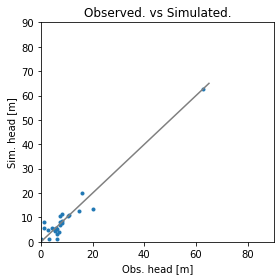

Error is - 2.8403370299105664
Params are - [7.44769879e-01 1.43038995e+01 1.55014995e+01 5.41562874e-01
 1.07833483e+00 5.31210614e-01 2.36782830e-03 6.36429556e-01
 1.59959610e-01 2.88352425e-01 1.83432353e-03 3.80996011e+00]


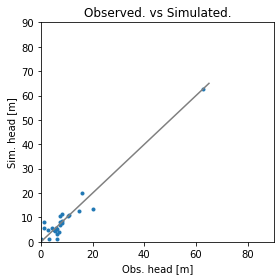

Error is - 2.84028046943058
Params are - [7.50434488e-01 1.41872051e+01 1.54202765e+01 5.39137250e-01
 1.07648669e+00 5.26515459e-01 2.37391308e-03 6.48665283e-01
 1.61325313e-01 2.89501677e-01 1.80623440e-03 3.80983089e+00]


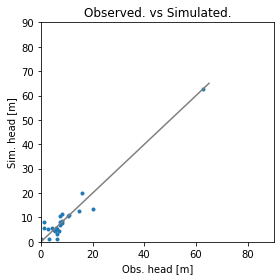

Error is - 2.8403181113802867
Params are - [7.51307722e-01 1.40443585e+01 1.53380564e+01 5.40987460e-01
 1.07272448e+00 5.35113367e-01 2.37300214e-03 6.48858507e-01
 1.62390710e-01 2.89185248e-01 1.78764451e-03 3.82065554e+00]


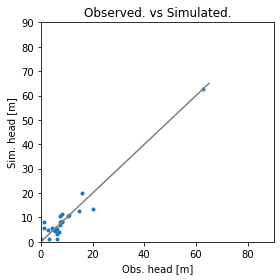

Error is - 2.8401764873169957
Params are - [7.61385186e-01 1.43663983e+01 1.53602444e+01 5.39337959e-01
 1.08024117e+00 5.19952746e-01 2.37344417e-03 6.43764520e-01
 1.60152399e-01 2.87700602e-01 1.82365105e-03 3.81274120e+00]


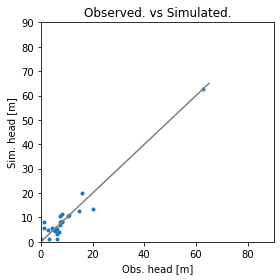

Error is - 2.8401359584688786
Params are - [7.72302177e-01 1.44103519e+01 1.52340258e+01 5.41110226e-01
 1.08050271e+00 5.21228433e-01 2.37222795e-03 6.39379433e-01
 1.59976461e-01 2.85756949e-01 1.82388947e-03 3.82472190e+00]


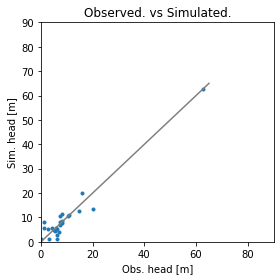

Error is - 2.8403076136388083
Params are - [7.57152498e-01 1.40094277e+01 1.53969998e+01 5.42299562e-01
 1.08697666e+00 5.28207269e-01 2.37651198e-03 6.44925572e-01
 1.58979257e-01 2.86825458e-01 1.82921725e-03 3.82469230e+00]


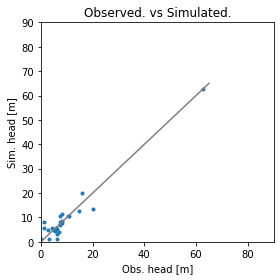

Error is - 2.840111807509587
Params are - [7.56287316e-01 1.42410522e+01 1.53222632e+01 5.44450284e-01
 1.08363883e+00 5.27535454e-01 2.37149782e-03 6.38824541e-01
 1.60166875e-01 2.89124260e-01 1.81028690e-03 3.82413247e+00]


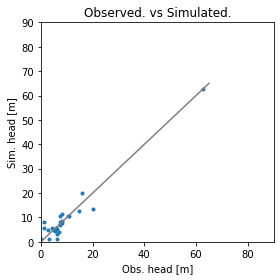

Error is - 2.8399791553625238
Params are - [7.59467319e-01 1.42016141e+01 1.51971148e+01 5.49998146e-01
 1.08607646e+00 5.34340689e-01 2.36846445e-03 6.31130179e-01
 1.60217450e-01 2.89253328e-01 1.79729952e-03 3.84119337e+00]


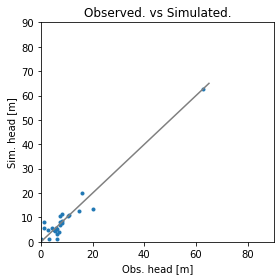

Error is - 2.8402195205638403
Params are - [7.60466757e-01 1.41690434e+01 1.53148800e+01 5.42257354e-01
 1.07504458e+00 5.25716361e-01 2.36915054e-03 6.44079836e-01
 1.61351756e-01 2.90229619e-01 1.79661302e-03 3.83026173e+00]


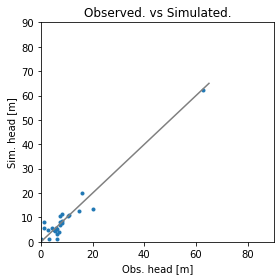

Error is - 2.8401159303128836
Params are - [7.60081614e-01 1.42084115e+01 1.53701435e+01 5.41220578e-01
 1.07796016e+00 5.23851921e-01 2.38033406e-03 6.45016180e-01
 1.61074167e-01 2.88247190e-01 1.79976657e-03 3.82000699e+00]


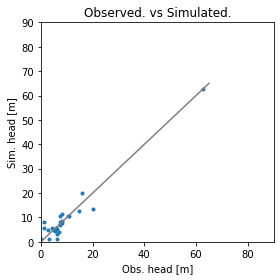

Error is - 2.8400192825458976
Params are - [7.61959131e-01 1.41622580e+01 1.52770306e+01 5.43154342e-01
 1.08168994e+00 5.28600684e-01 2.37268548e-03 6.40490883e-01
 1.60882232e-01 2.89030106e-01 1.80718673e-03 3.80896140e+00]


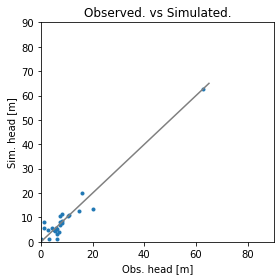

Error is - 2.8401580564020836
Params are - [7.56724495e-01 1.41975934e+01 1.52842540e+01 5.39013316e-01
 1.07443651e+00 5.32229441e-01 2.36931088e-03 6.42947332e-01
 1.61670920e-01 2.91161475e-01 1.79965006e-03 3.82094140e+00]


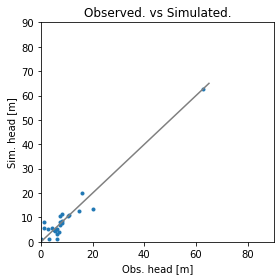

Error is - 2.8401026124288813
Params are - [7.67721810e-01 1.39040882e+01 1.51821573e+01 5.45547375e-01
 1.08190241e+00 5.38334356e-01 2.36819877e-03 6.40474341e-01
 1.61238501e-01 2.85997572e-01 1.80802993e-03 3.84014733e+00]


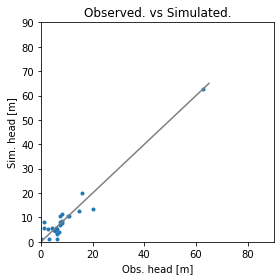

Error is - 2.839967083559503
Params are - [7.68952990e-01 1.40005922e+01 1.51755275e+01 5.46220290e-01
 1.08658853e+00 5.41636931e-01 2.37129904e-03 6.32953626e-01
 1.60313080e-01 2.86456932e-01 1.79270151e-03 3.84271822e+00]


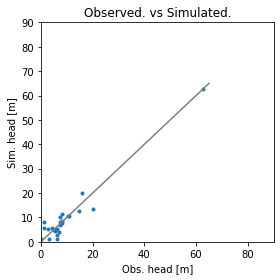

Error is - 2.8399297577584703
Params are - [7.79134450e-01 1.38281739e+01 1.50176233e+01 5.50906423e-01
 1.09277003e+00 5.55572931e-01 2.37001222e-03 6.22961446e-01
 1.59923707e-01 2.84213472e-01 1.77531991e-03 3.86580116e+00]


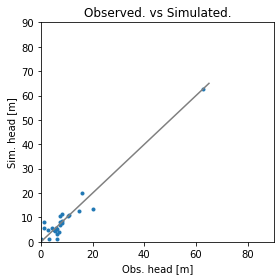

Error is - 2.8398785708279077
Params are - [7.66845861e-01 1.41336134e+01 1.51809541e+01 5.52327867e-01
 1.08460407e+00 5.37912028e-01 2.37128716e-03 6.29088416e-01
 1.59816681e-01 2.88058945e-01 1.78643942e-03 3.84307323e+00]


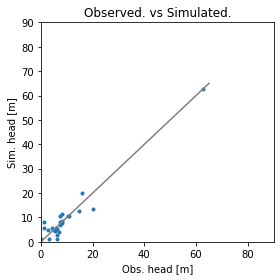

Error is - 2.8397871762766447
Params are - [7.72888961e-01 1.41216617e+01 1.50619255e+01 5.61681148e-01
 1.08761826e+00 5.45402905e-01 2.37026507e-03 6.17648294e-01
 1.59049803e-01 2.87783810e-01 1.76696766e-03 3.86153947e+00]


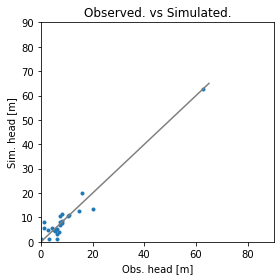

Error is - 2.840047981894092
Params are - [7.67298088e-01 1.41417711e+01 1.51436422e+01 5.47480179e-01
 1.07773890e+00 5.37490486e-01 2.36836363e-03 6.33145735e-01
 1.60670668e-01 2.85523099e-01 1.80911717e-03 3.85376062e+00]


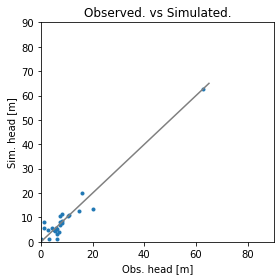

Error is - 2.8399229267671466
Params are - [7.68798461e-01 1.42998031e+01 1.51043970e+01 5.47829066e-01
 1.07497456e+00 5.37332393e-01 2.36589280e-03 6.29844906e-01
 1.62263099e-01 2.89145465e-01 1.77414975e-03 3.83880726e+00]


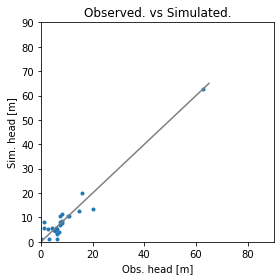

Error is - 2.8397814513409187
Params are - [7.82319826e-01 1.39821167e+01 1.49292716e+01 5.52290469e-01
 1.08171956e+00 5.43815038e-01 2.36996731e-03 6.29946713e-01
 1.61534193e-01 2.86846724e-01 1.76390985e-03 3.86549781e+00]


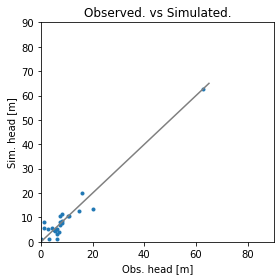

Error is - 2.839788251898907
Params are - [7.99866507e-01 1.38115688e+01 1.46412539e+01 5.58802988e-01
 1.08283901e+00 5.53745405e-01 2.36919971e-03 6.23578105e-01
 1.62264713e-01 2.85706467e-01 1.73080101e-03 3.89633116e+00]


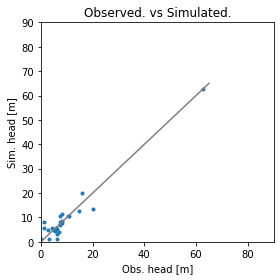

Error is - 2.839638611192311
Params are - [7.84426026e-01 1.40839427e+01 1.49324677e+01 5.54610854e-01
 1.08558565e+00 5.44137147e-01 2.36689911e-03 6.20845597e-01
 1.60316847e-01 2.86029791e-01 1.78074888e-03 3.86877585e+00]


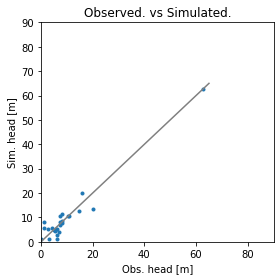

Error is - 2.8394733585845446
Params are - [8.01421795e-01 1.40323115e+01 1.46885633e+01 5.62347657e-01
 1.09013512e+00 5.52947991e-01 2.36339213e-03 6.06935754e-01
 1.59812614e-01 2.84293847e-01 1.76800611e-03 3.89824832e+00]


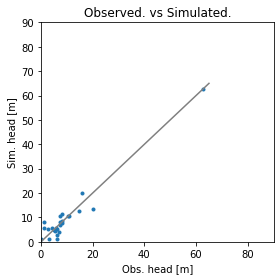

Error is - 2.8395668597927304
Params are - [7.81219597e-01 1.40793158e+01 1.49334781e+01 5.54839133e-01
 1.08954286e+00 5.49474851e-01 2.37070192e-03 6.19240363e-01
 1.60033880e-01 2.84312554e-01 1.78560243e-03 3.85967611e+00]


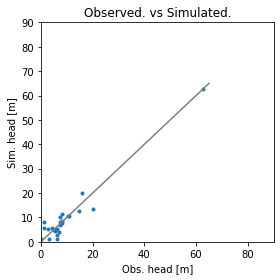

Error is - 2.839664457193347
Params are - [7.89044376e-01 1.40310529e+01 1.49056414e+01 5.60720807e-01
 1.09266865e+00 5.45836005e-01 2.37077342e-03 6.16421706e-01
 1.59441876e-01 2.82239211e-01 1.78022412e-03 3.87545222e+00]


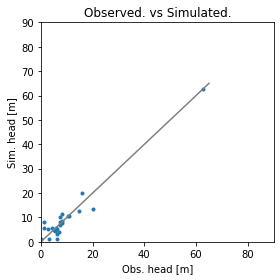

Error is - 2.839841579363342
Params are - [7.76257061e-01 1.37550778e+01 1.49011390e+01 5.61892328e-01
 1.08863011e+00 5.60938275e-01 2.36761393e-03 6.16163317e-01
 1.61047237e-01 2.87057447e-01 1.74870715e-03 3.88012678e+00]


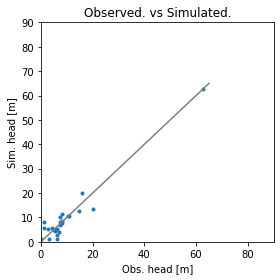

Error is - 2.839761747678767
Params are - [7.91173532e-01 1.38814627e+01 1.46868539e+01 5.65227268e-01
 1.09295098e+00 5.64495846e-01 2.35738779e-03 6.05717759e-01
 1.59945043e-01 2.84368916e-01 1.76432016e-03 3.89486166e+00]


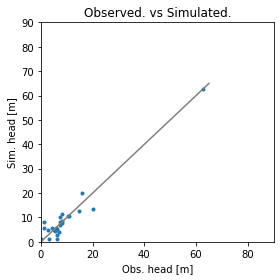

Error is - 2.839524764806231
Params are - [7.87441956e-01 1.41820150e+01 1.47922894e+01 5.64180452e-01
 1.09085016e+00 5.54373660e-01 2.36772125e-03 6.04466835e-01
 1.59565133e-01 2.86347091e-01 1.74877183e-03 3.88384036e+00]


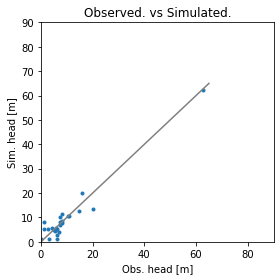

Error is - 2.839818936977219
Params are - [7.91222990e-01 1.39510394e+01 1.47722458e+01 5.65031028e-01
 1.09719888e+00 5.58031392e-01 2.36744933e-03 6.07015624e-01
 1.59948710e-01 2.86958897e-01 1.73762704e-03 3.87524037e+00]


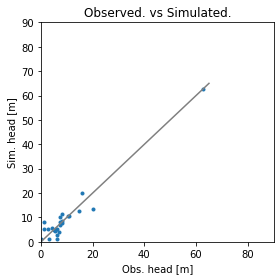

Error is - 2.8395941202911574
Params are - [8.01439256e-01 1.38953495e+01 1.45547266e+01 5.73002979e-01
 1.09583266e+00 5.71826312e-01 2.36225479e-03 5.94091266e-01
 1.59581559e-01 2.83106688e-01 1.72796420e-03 3.93108609e+00]


KeyboardInterrupt: 

In [88]:
# run optimization 

"""             {-12:Alluvium_Aua, 
               -14:Alluvium_Fagaalu, 
               -15:Alluvium_minor,
               -13:Alluvium_Utulei,
               -11:Alluvium_Vaipito,
               -10:Alluvium_Vatia,
               -50:Dikes,
               -30:Pago_inner_E,
               -40:Pago_inner_W,
               -20:Pago_outer,
               -60:Trachyte,     
               -16:Alluvium_Laulii}}   """

# Start
# params = [4.6, 13.0, 0.1, 5.0, 2.6, 0.4, 0.3, 0.1, 0.5, 0.6, 0.3]
# Better
# params = [2.1, 28.6, 0.05, 7.2, 1.8, 0.7, 0.01, 0.15, 0.4, 1.5, 0.01]
# Better
# params = [2.6, 39, 1, 14, 3.7, 1.2, 0.001, 0.37, 0.9, 0.7, 0.003, 1]
#[0.7, 32, 6.8, 1.9, 1.5, 5.0, 0.001, 1.0, 0.25, 0.2, 0.0015, 2.5] 


params = [0.7, 16, 16,  0.5, 1.0, 0.5, 0.0023, 0.7, 0.17, 0.3, 0.0017, 3.75] 

# The main optimization function
results = opt.minimize(calibrateo, x0= params, method="Nelder-Mead",tol = 0.1)